In [1]:
import numpy as np
from numpy import pi, sqrt, exp, arcsin, arctan, arccos
import numpy.ma as ma
from scipy import stats
from scipy import optimize

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use('pgf')
if mpl.get_backend() == 'pgf':
    pass
else:
    %matplotlib inline 
    %config InlineBackend.figure_format = 'retina'
    
FIGURE_PATH='figures/'
DATA_PATH='data/Aktivierung/'

from scipy.constants import h, m_e, k, N_A, pi, e, hbar, u, k, mu_0, c

from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.stats import chi2
from scipy.special import gamma
import scipy.odr as odr

h_lit = h
N_A_lit = N_A

In [2]:
def cm2inch(lst):
    inch = 2.54
    if isinstance(lst, list):
        return [x/inch for x in lst] 
    elif isinstance(lst, float):
        return lst/inch

default_width =  cm2inch(21/sqrt(2)) # 5.78853 # approx 14.7cm
default_ratio = (sqrt(5.0) - 1.0) / 2.0 # golden mean
print(default_width)

5.846158427132873


In [3]:
default_width = cm2inch(21/sqrt(2))
default_ratio = default_ratio = (sqrt(5.0) - 1.0) / 2.0 # golden mean

In [4]:
from matplotlib import rcParams
from matplotlib import cycler
if mpl.get_backend() == 'pgf':
    rcParams.update({'legend.loc' : 'best'})
    rcParams.update({
        "text.usetex": True,
        "pgf.texsystem": "xelatex",
        "pgf.rcfonts": False,
        "font.family": "serif",
        "font.serif": [],
        "font.sans-serif": [],
        "font.monospace": [],
        "figure.figsize": [default_width, default_width * default_ratio],
        "pgf.preamble": [
            r"\usepackage[utf8x]{inputenc}",
            r"\usepackage[T1]{fontenc}",
        ],
        "figure.constrained_layout.use": True,
    })
    rcParams.update({'savefig.bbox' : 'standard'})
    rcParams.update({'savefig.pad_inches' : 0.0})
else:
    rcParams.update({'figure.autolayout': True})
    rcParams.update({'figure.figsize' : [15,9.47]})
    rcParams.update({'font.size' : 16})
rcParams.update({'errorbar.capsize' : 4})
rcParams.update({'legend.loc' : 'best'})
rcParams.update({'axes.prop_cycle': cycler('color', ["#cf115d", "#786eb3", "#bce333", "#99c1b8", "#0cc0aa", "#8547d9", "#76f014", "#ea85f5"])})
rcParams.update({'lines.markeredgecolor': 'black',
                 'lines.markerfacecolor': 'black'})

# 1.a)

## Grenzwellenlänge LiF

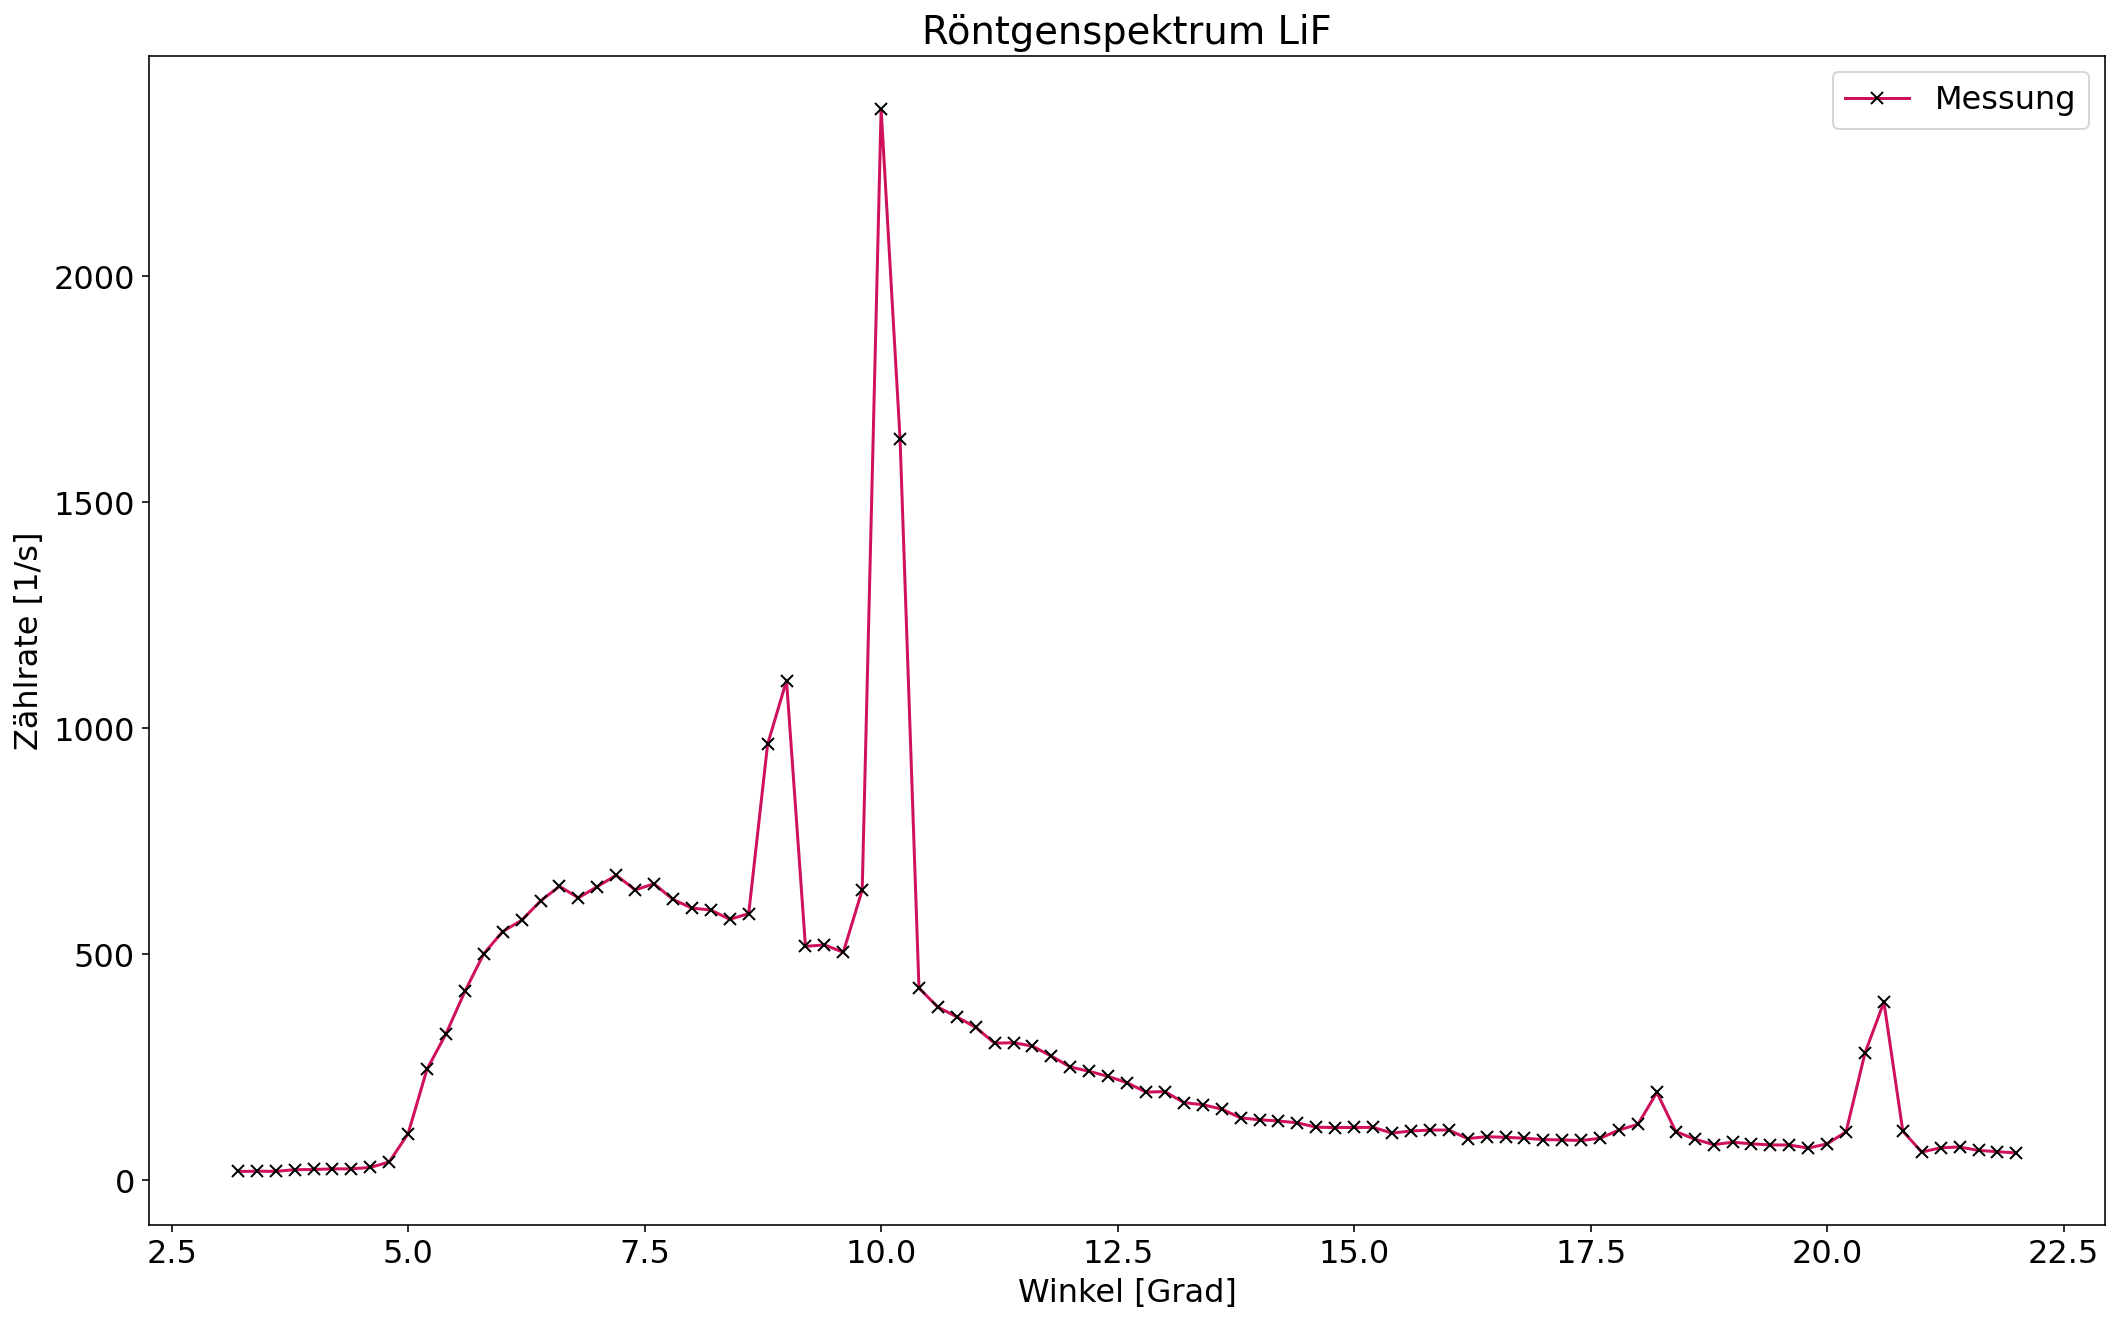

In [5]:
angle, n = np.loadtxt('data/Roentgenspektrum_LiF.txt', skiprows=1, usecols=(0,1), unpack=True)

plt.errorbar(angle, n, marker='x', label='Messung')
plt.title('Röntgenspektrum LiF')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'mess_LiF')
plt.show()

In [6]:
n0 = np.mean(n[:8])
print(angle[8])
n0_err = np.std(n[:8])
print(f'n0 = {n0} +/- {n0_err}')

4.8
n0 = 22.925 +/- 3.021485561772553


m = 472.8289854476285 +/- 8.855647962323664
b = -2245.5447379438515 +/- 47.018547419051394


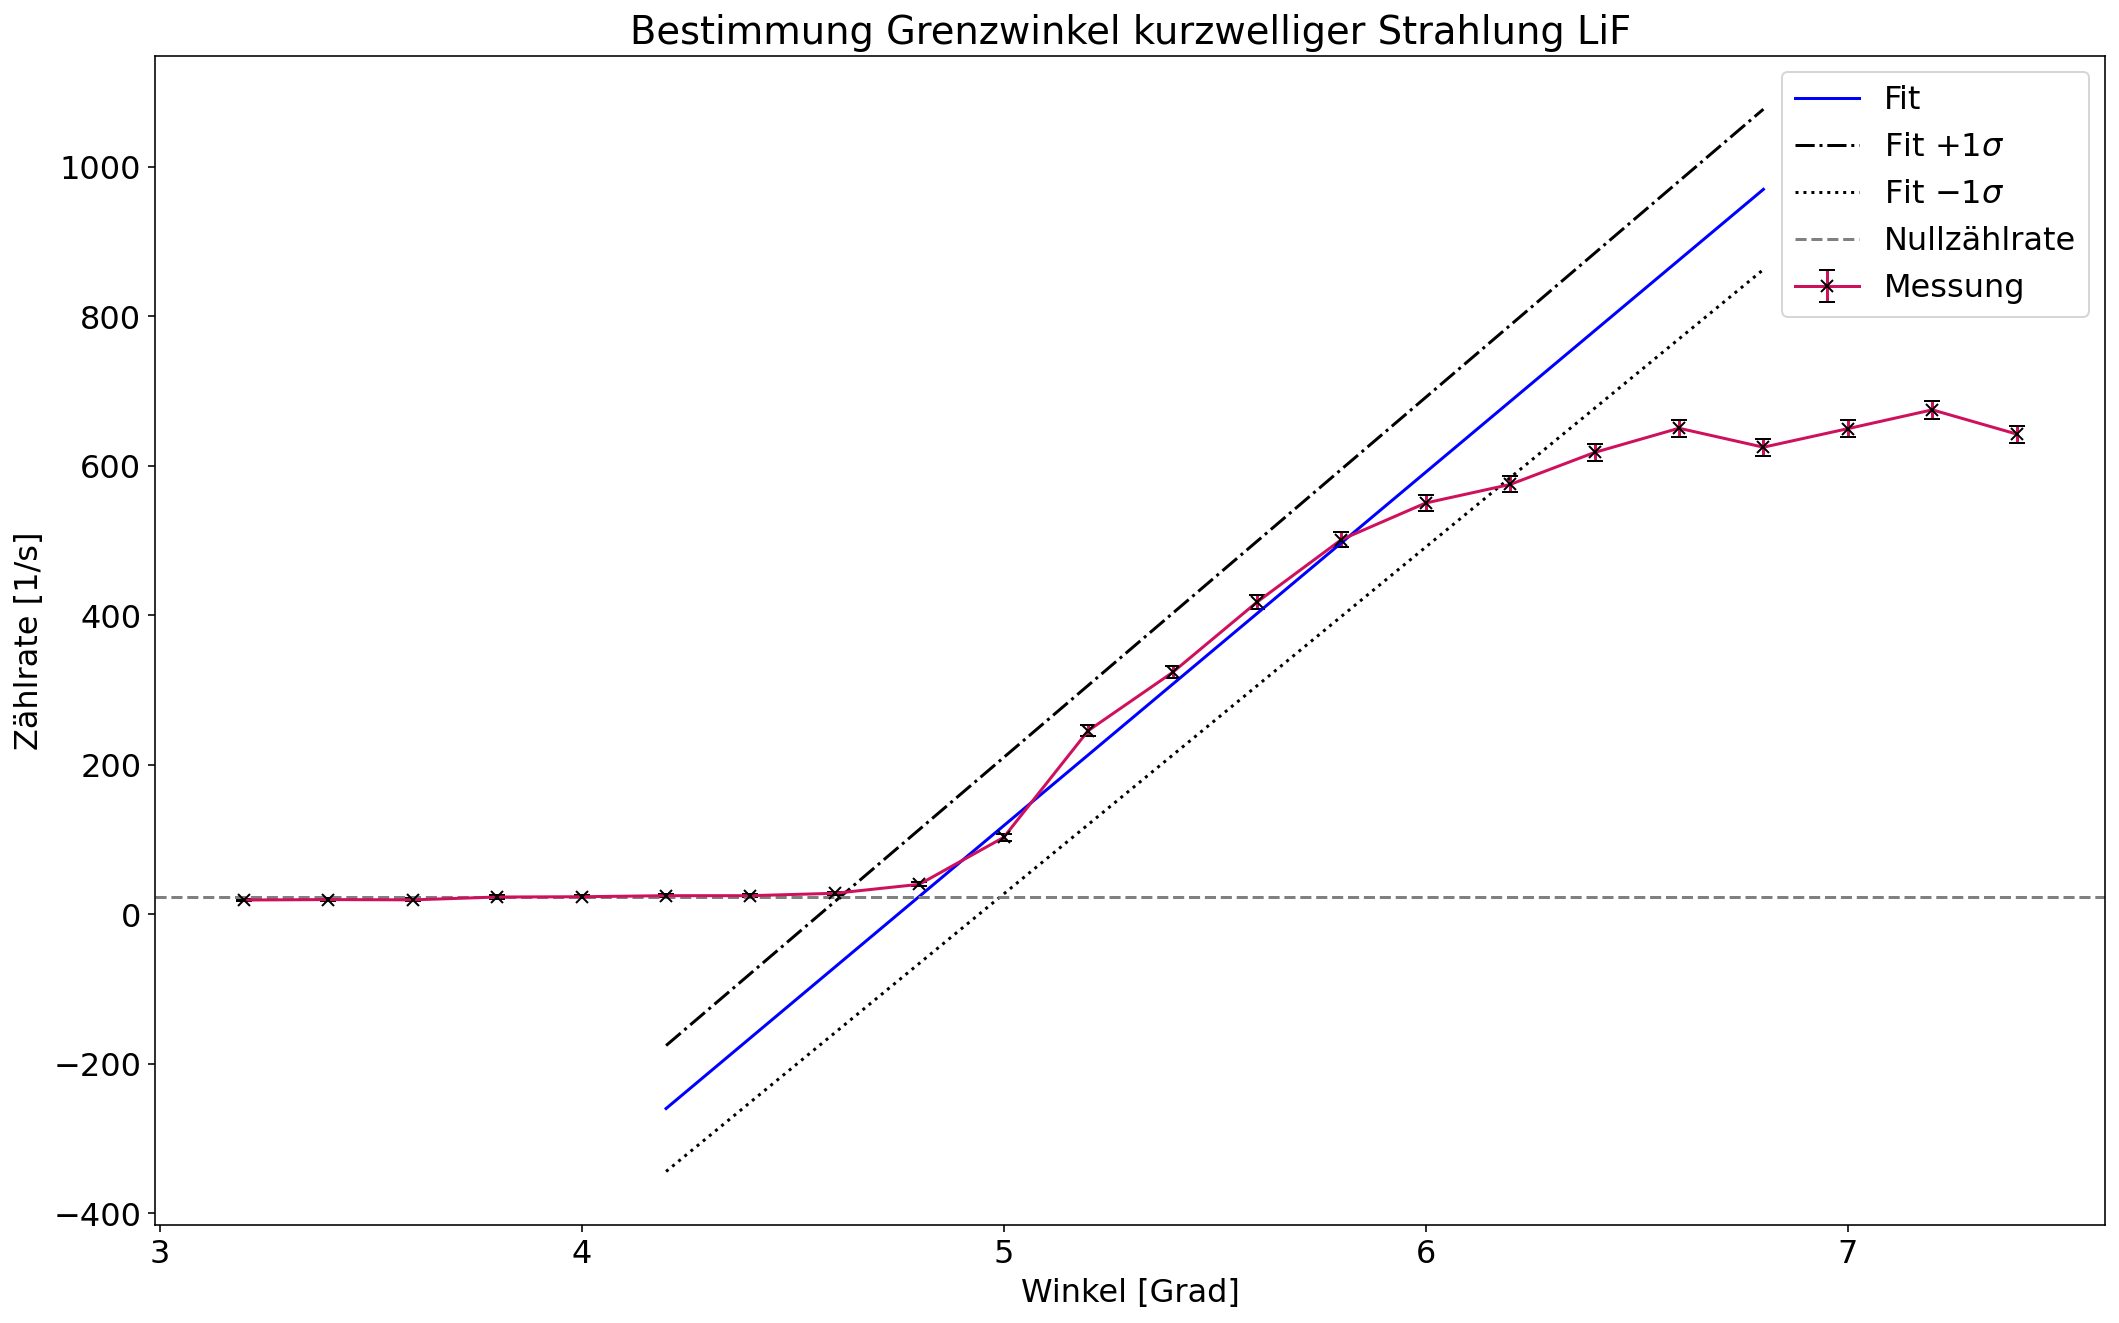

In [7]:
def linear(x, m, b):
    return m*x + b

t = 5
n_err = np.sqrt(n/t)

i,j = 9, 15
popt, pcov = curve_fit(linear, angle[i:j], n[i:j], sigma=n_err[i:j], absolute_sigma=True)
popt_err = np.sqrt(pcov.diagonal())

print(f'm = {popt[0]} +/- {popt_err[0]}')
print(f'b = {popt[1]} +/- {popt_err[1]}')

plt.errorbar(angle[angle<7.5], n[angle<7.5], yerr=n_err[angle<7.5], marker='x', label='Messung')

plt.plot(angle[i-4:j+4], linear(angle[i-4:j+4], *popt), color='b', label='Fit')
plt.plot(angle[i-4:j+4], linear(angle[i-4:j+4], *(popt+popt_err)), color='black', linestyle='-.', label=r'Fit $+1\sigma$')
plt.plot(angle[i-4:j+4], linear(angle[i-4:j+4], *(popt-popt_err)), color='black', linestyle=':',  label=r'Fit $-1\sigma$')

plt.axhline(y=n0, color='gray', linestyle='--', label='Nullzählrate')

plt.title('Bestimmung Grenzwinkel kurzwelliger Strahlung LiF')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'grenzwinkel_LiF')
plt.show()

In [8]:
ROOTS = np.array([])
for c_err in [0,1,-1]:
    p = popt + c_err * popt_err

    def func2(x):
        return linear(x, *p) - n0 # Um Nullzählrate versetzte Funktion

    # Guess für Nullstelle 
    guess_root = 4.8

    root = optimize.root(func2, guess_root) # bestimme Nullstelle
    
    ROOTS = np.append(ROOTS,root.x[0])
    
θ_gr = np.mean(ROOTS) # degree;
Δθ_gr = np.std(ROOTS) / len(ROOTS)

print(f'θ_gr = {θ_gr} +/- {Δθ_gr}')

θ_gr = 4.800018108354915 +/- 0.05154107752275269


### Planck'sches Wirkumsquantum

In [9]:
d = 201.4e-12
a = 2*d
λ_gr = a * np.sin(θ_gr*pi/180)
Δλ_gr = a * np.cos(θ_gr) * Δθ_gr * pi/180

print(f'λ_gr = {λ_gr} +/- {Δλ_gr}')

λ_gr = 3.3705562152885385e-11 +/- 3.171121309363252e-14


In [10]:
U = 35e3 # V; 
ΔU = 50 

h = e * U * λ_gr / c 
Δh = h * np.sqrt((Δλ_gr/λ_gr)**2 +(ΔU/U))

print(f'h = {h} +/- {Δh}')
print(f'{abs(h-h_lit)/Δh:.2f} sigma')

h = 6.304625729115471e-34 +/- 2.383662672554402e-35
1.35 sigma


### Spektrum zweiter Ordnung

In [11]:
θ_gr2 = np.arcsin(λ_gr/d) # rad;
Δθ_gr2 = Δλ_gr / (d * np.sqrt(1 - (λ_gr/d)**2))

print(f'θ_gr2 = {θ_gr2 * 180/pi} +/- {Δθ_gr2 * 180/pi}')

θ_gr2 = 9.634145137561434 +/- 0.009150497517097555


# 1 b)

In [12]:
MU = np.array([])
MU_ERR = np.array([])

### $K_{\beta}$ 1. Ordnung

mu = 8.902327194431438 +/- 0.11373332385723912


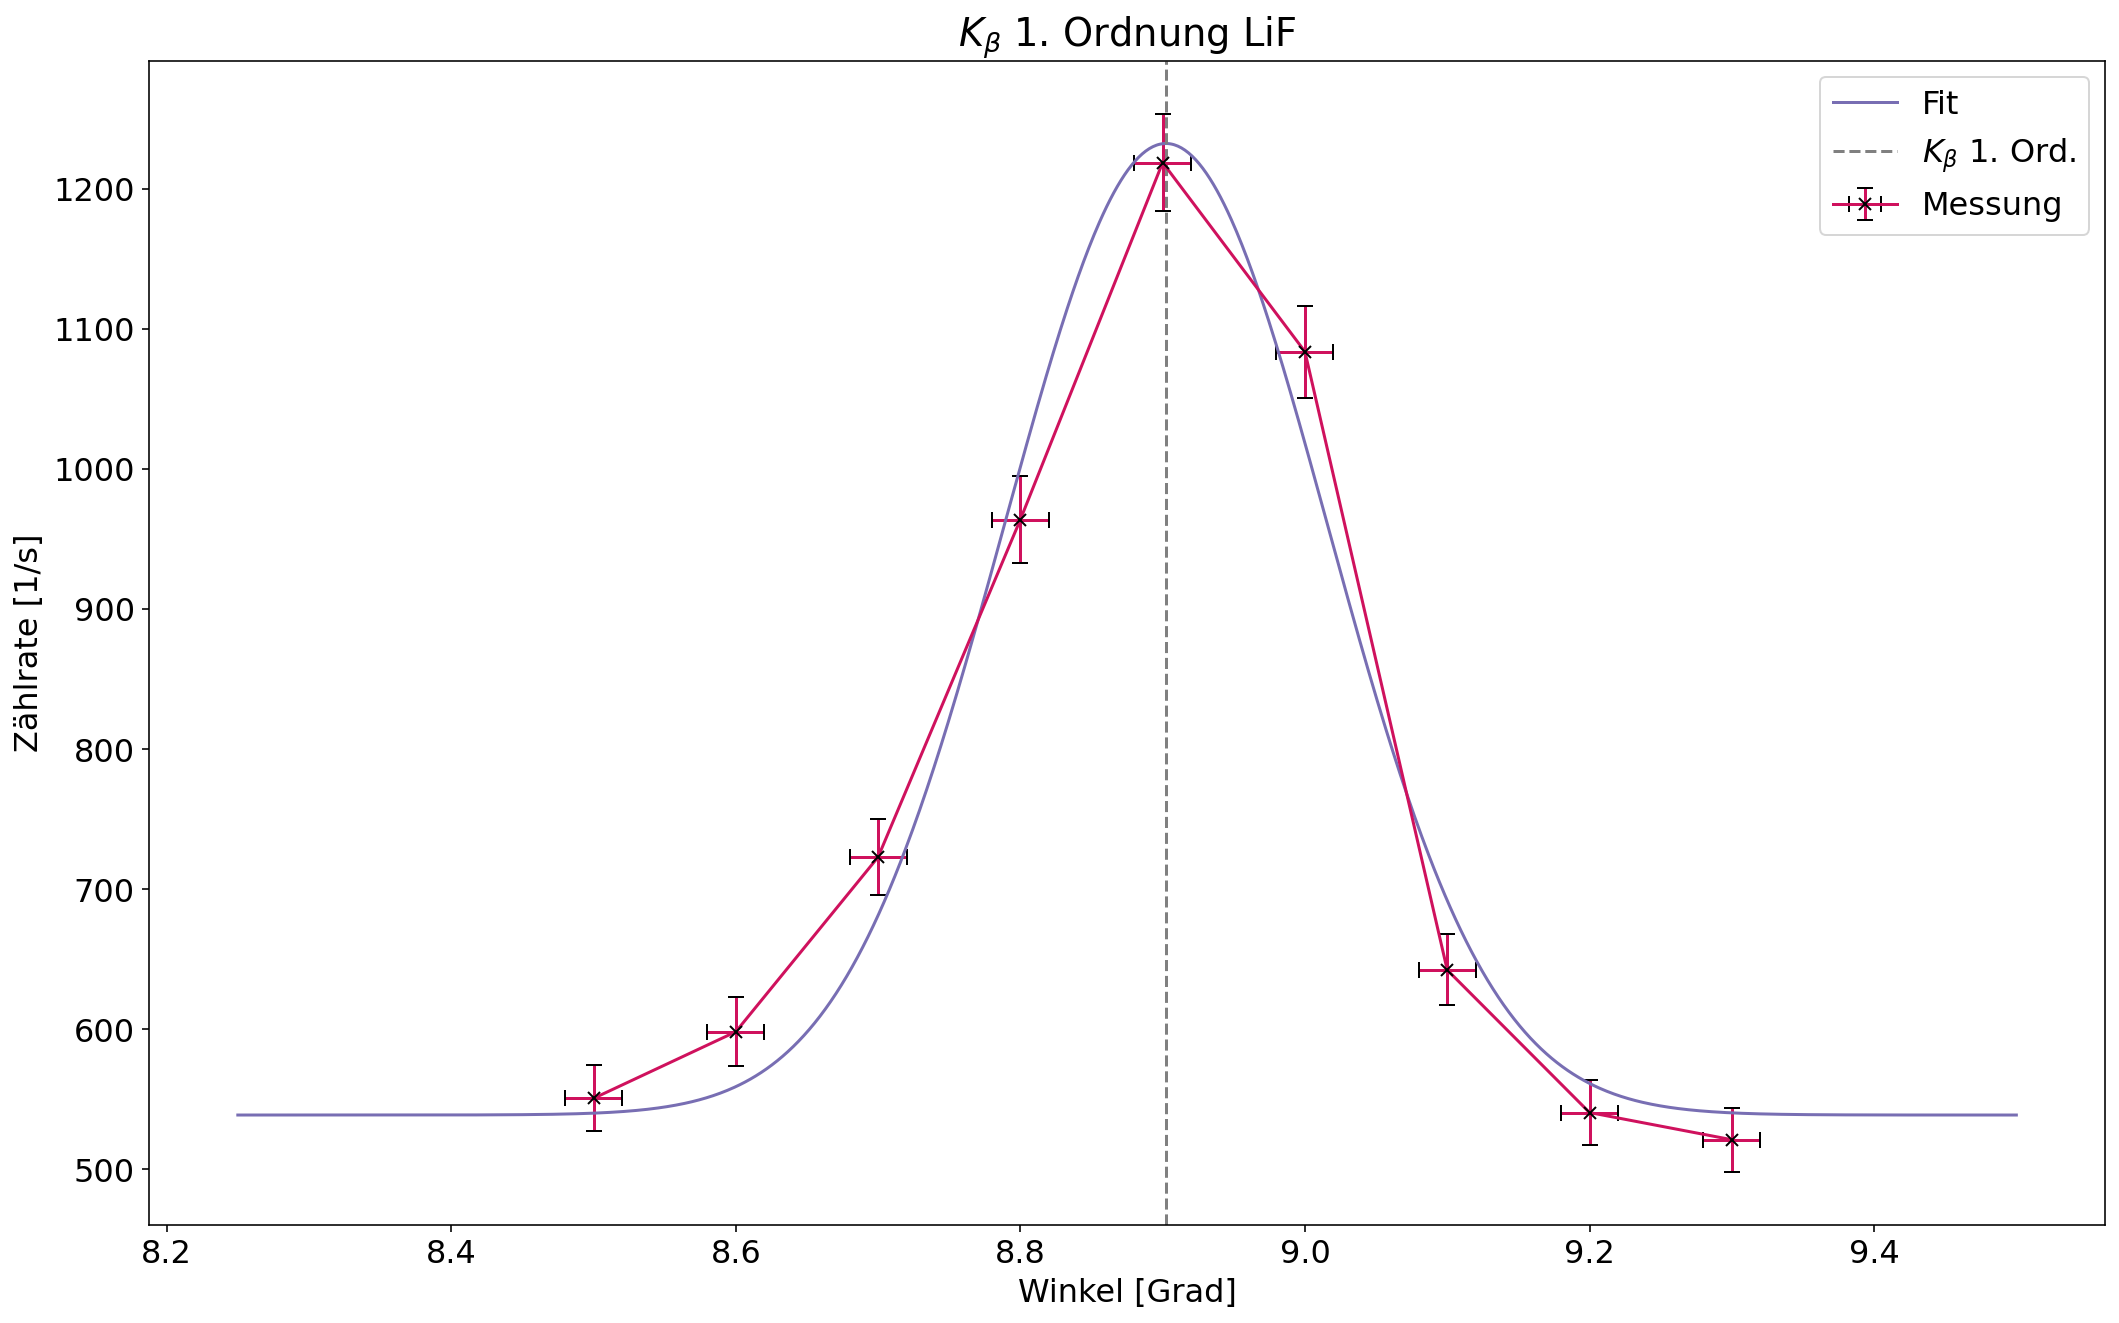

In [13]:
θ, n = np.loadtxt('data/K-Linien_erster_Ordnung.txt', skiprows=1, usecols=(0,1), unpack=True)
Δθ = 0.02
t = 20
Δn = np.sqrt(n)

def gaussian (x, A, mu, sig, c):
    return A / (np.sqrt(2*pi) * sig) * np.exp(-(x-mu)**2/2/sig**2) + c

index = (θ >= 8.5) & (θ <= 9.3)
popt, pcov = curve_fit(gaussian, θ[index], n[index], sigma=Δn[index], p0=[1800,10.3, 1, 300], absolute_sigma=True)

mu = popt[1] 
mu_err = popt[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu = {mu} +/- {mu_err}')

plt.errorbar(θ[index], n[index], xerr=Δθ, yerr=Δn[index], marker='x', label='Messung')
x = np.linspace(8.25, 9.5, 1000)
plt.plot(x, gaussian(x, *popt), label='Fit')

plt.axvline(x=mu, color='gray', linestyle='--', label=r'$K_{\beta}$ 1. Ord.')

plt.title(r'$K_{\beta}$ 1. Ordnung LiF')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'Kb_1ord')
plt.show()

### $K_{\alpha}$ 1. Ordnung

mu = 10.062519943389525 +/- 0.11042384061298653
H = 0.2600282733247633 +/- 0.004693295105469619


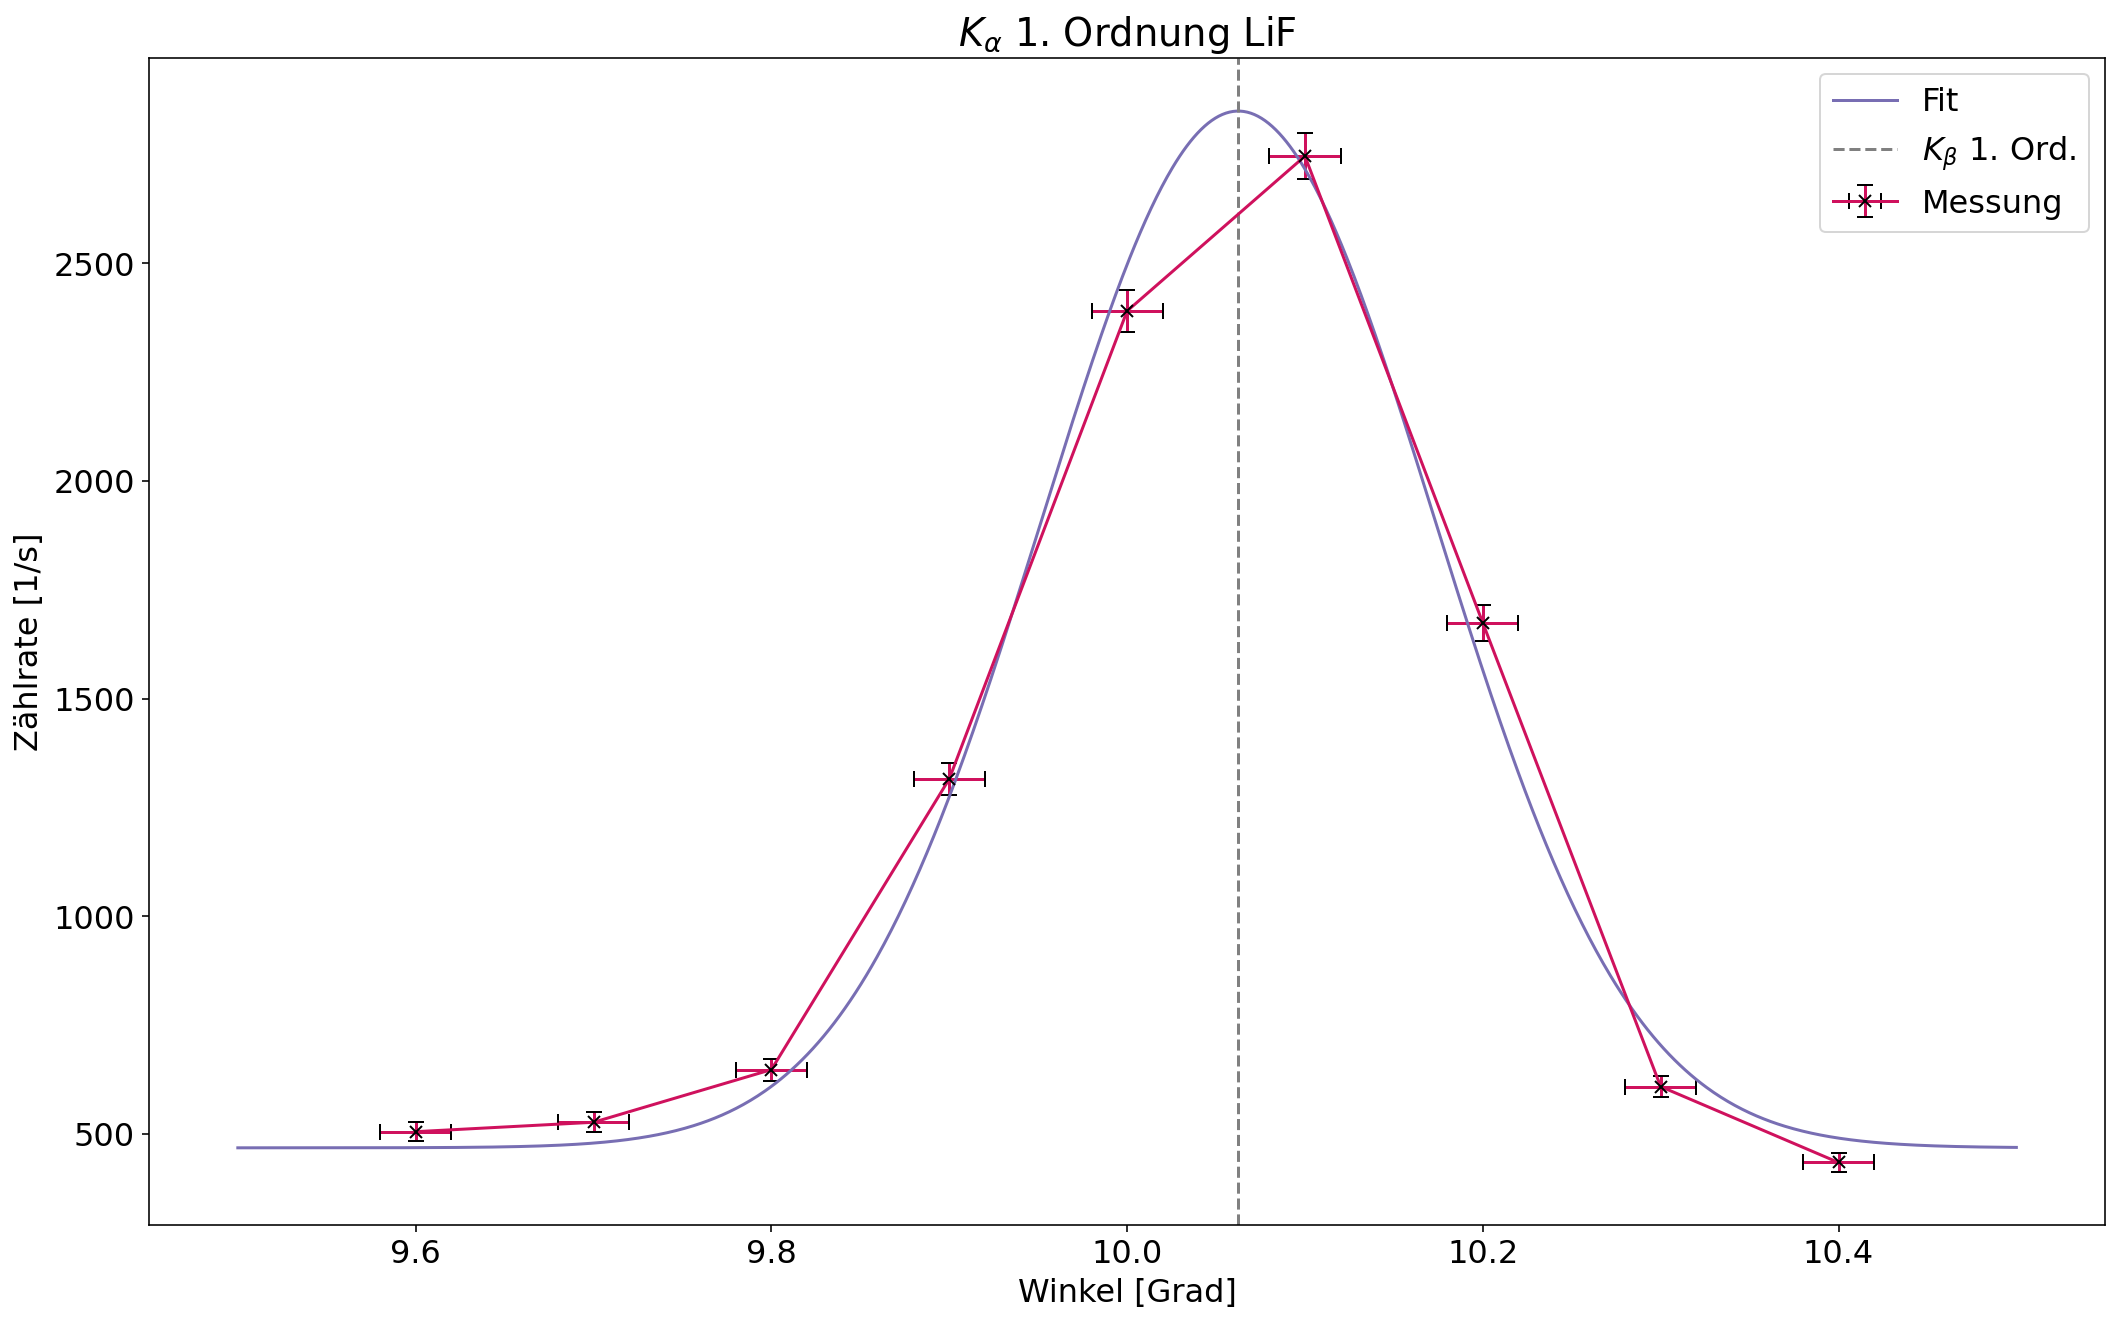

In [14]:
θ, n = np.loadtxt('data/K-Linien_erster_Ordnung.txt', skiprows=1, usecols=(0,1), unpack=True)
Δθ = 0.02
t = 20
Δn = np.sqrt(n)

def gaussian (x, A, mu, sig, c):
    return A / (np.sqrt(2*pi) * sig) * np.exp(-(x-mu)**2/2/sig**2) + c

index = (θ >= 9.6) & (θ <= 10.4)
popt, pcov = curve_fit(gaussian, θ[index], n[index], sigma=Δn[index], p0=[1800,10.3, 1, 300], absolute_sigma=True)

mu = popt[1] 
mu_err = popt[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu = {mu} +/- {mu_err}')

sig = popt[2]
sig_err = np.sqrt(pcov.diagonal()[2])
H = 2 * np.sqrt(2*np.log(2)) * sig
H_err = 2 * np.sqrt(2*np.log(2)) * sig_err
print(f'H = {H} +/- {H_err}')

plt.errorbar(θ[index], n[index], xerr=Δθ, yerr=Δn[index], marker='x', label='Messung')
x = np.linspace(9.5, 10.5, 1000)
plt.plot(x, gaussian(x, *popt), label='Fit')

plt.axvline(x=mu, color='gray', linestyle='--', label=r'$K_{\beta}$ 1. Ord.')

plt.title(r'$K_{\alpha}$ 1. Ordnung LiF')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'Ka_1ord')
plt.show()

## $K_{\beta}$ 2. Ordnung

mu = 18.171682227843167 +/- 0.12550183571179485


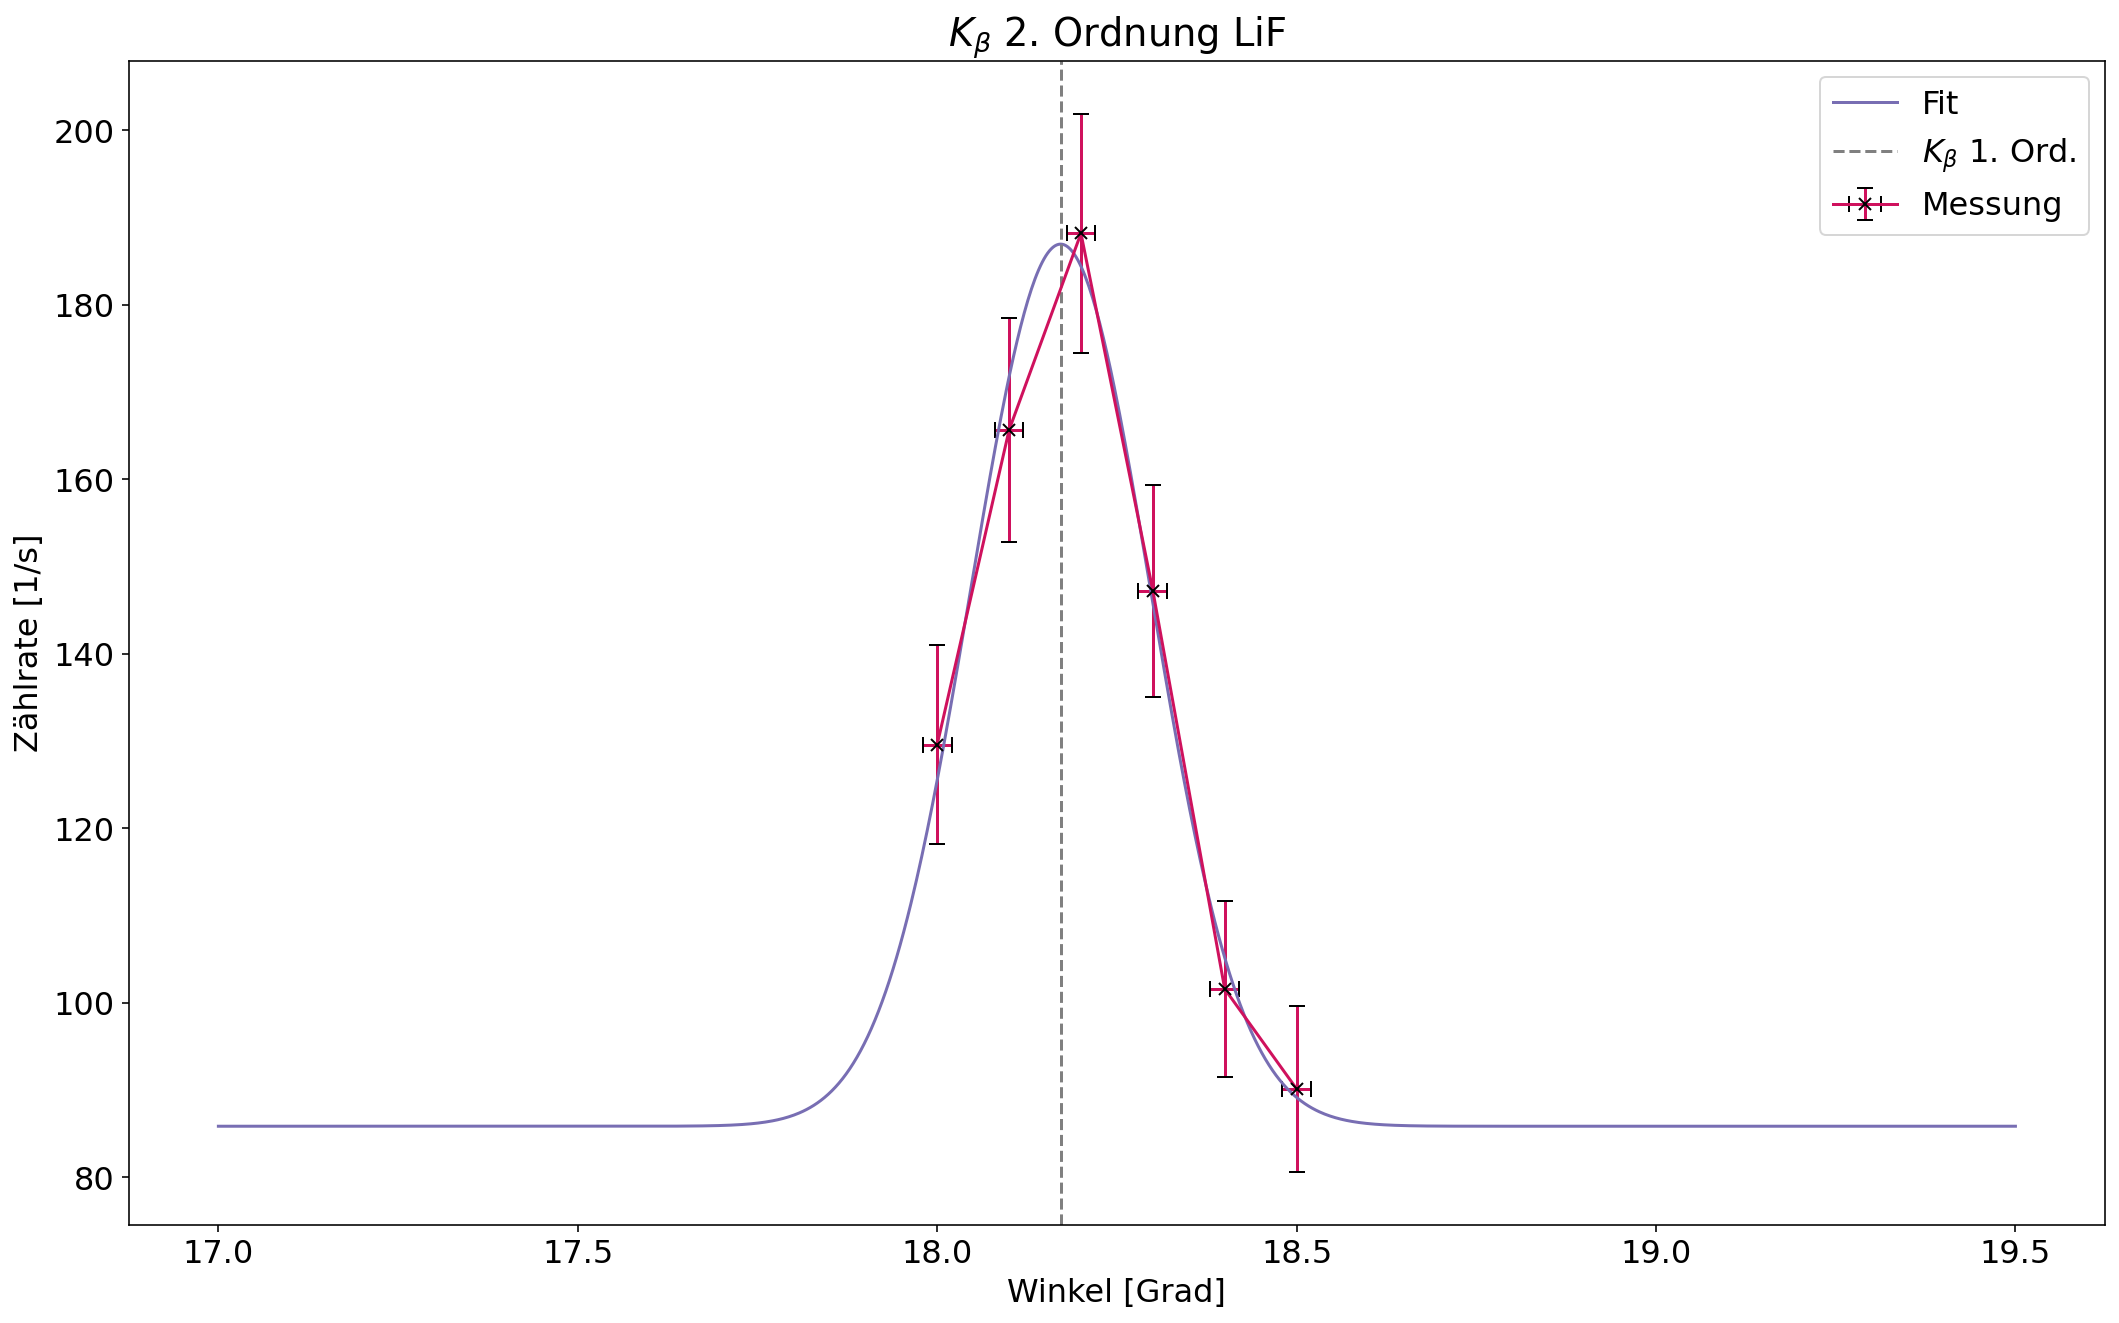

In [15]:
θ, n = np.loadtxt('data/K-Linien_zweiter_Ordnung.txt', skiprows=1, usecols=(0,1), unpack=True)
Δθ = 0.02
t = 20
Δn = np.sqrt(n)

def gaussian (x, A, mu, sig, c):
    return A / (np.sqrt(2*pi) * sig) * np.exp(-(x-mu)**2/2/sig**2) + c

index = (θ >= 18) & (θ <= 18.5)
popt, pcov = curve_fit(gaussian, θ[index], n[index], sigma=Δn[index], p0=[800,18.5, 1, 300], absolute_sigma=True)

mu = popt[1] 
mu_err = popt[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu = {mu} +/- {mu_err}')

plt.errorbar(θ[index], n[index], xerr=Δθ, yerr=Δn[index], marker='x', label='Messung')
x = np.linspace(17, 19.5, 1000)
plt.plot(x, gaussian(x, *popt), label='Fit')

plt.axvline(x=mu, color='gray', linestyle='--', label=r'$K_{\beta}$ 1. Ord.')

plt.title(r'$K_{\beta}$ 2. Ordnung LiF')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'Kb_2ord')
plt.show()

### $K_{\alpha}$ 2. Ordnung

mu = 20.53325089367774 +/- 0.12749788764188708


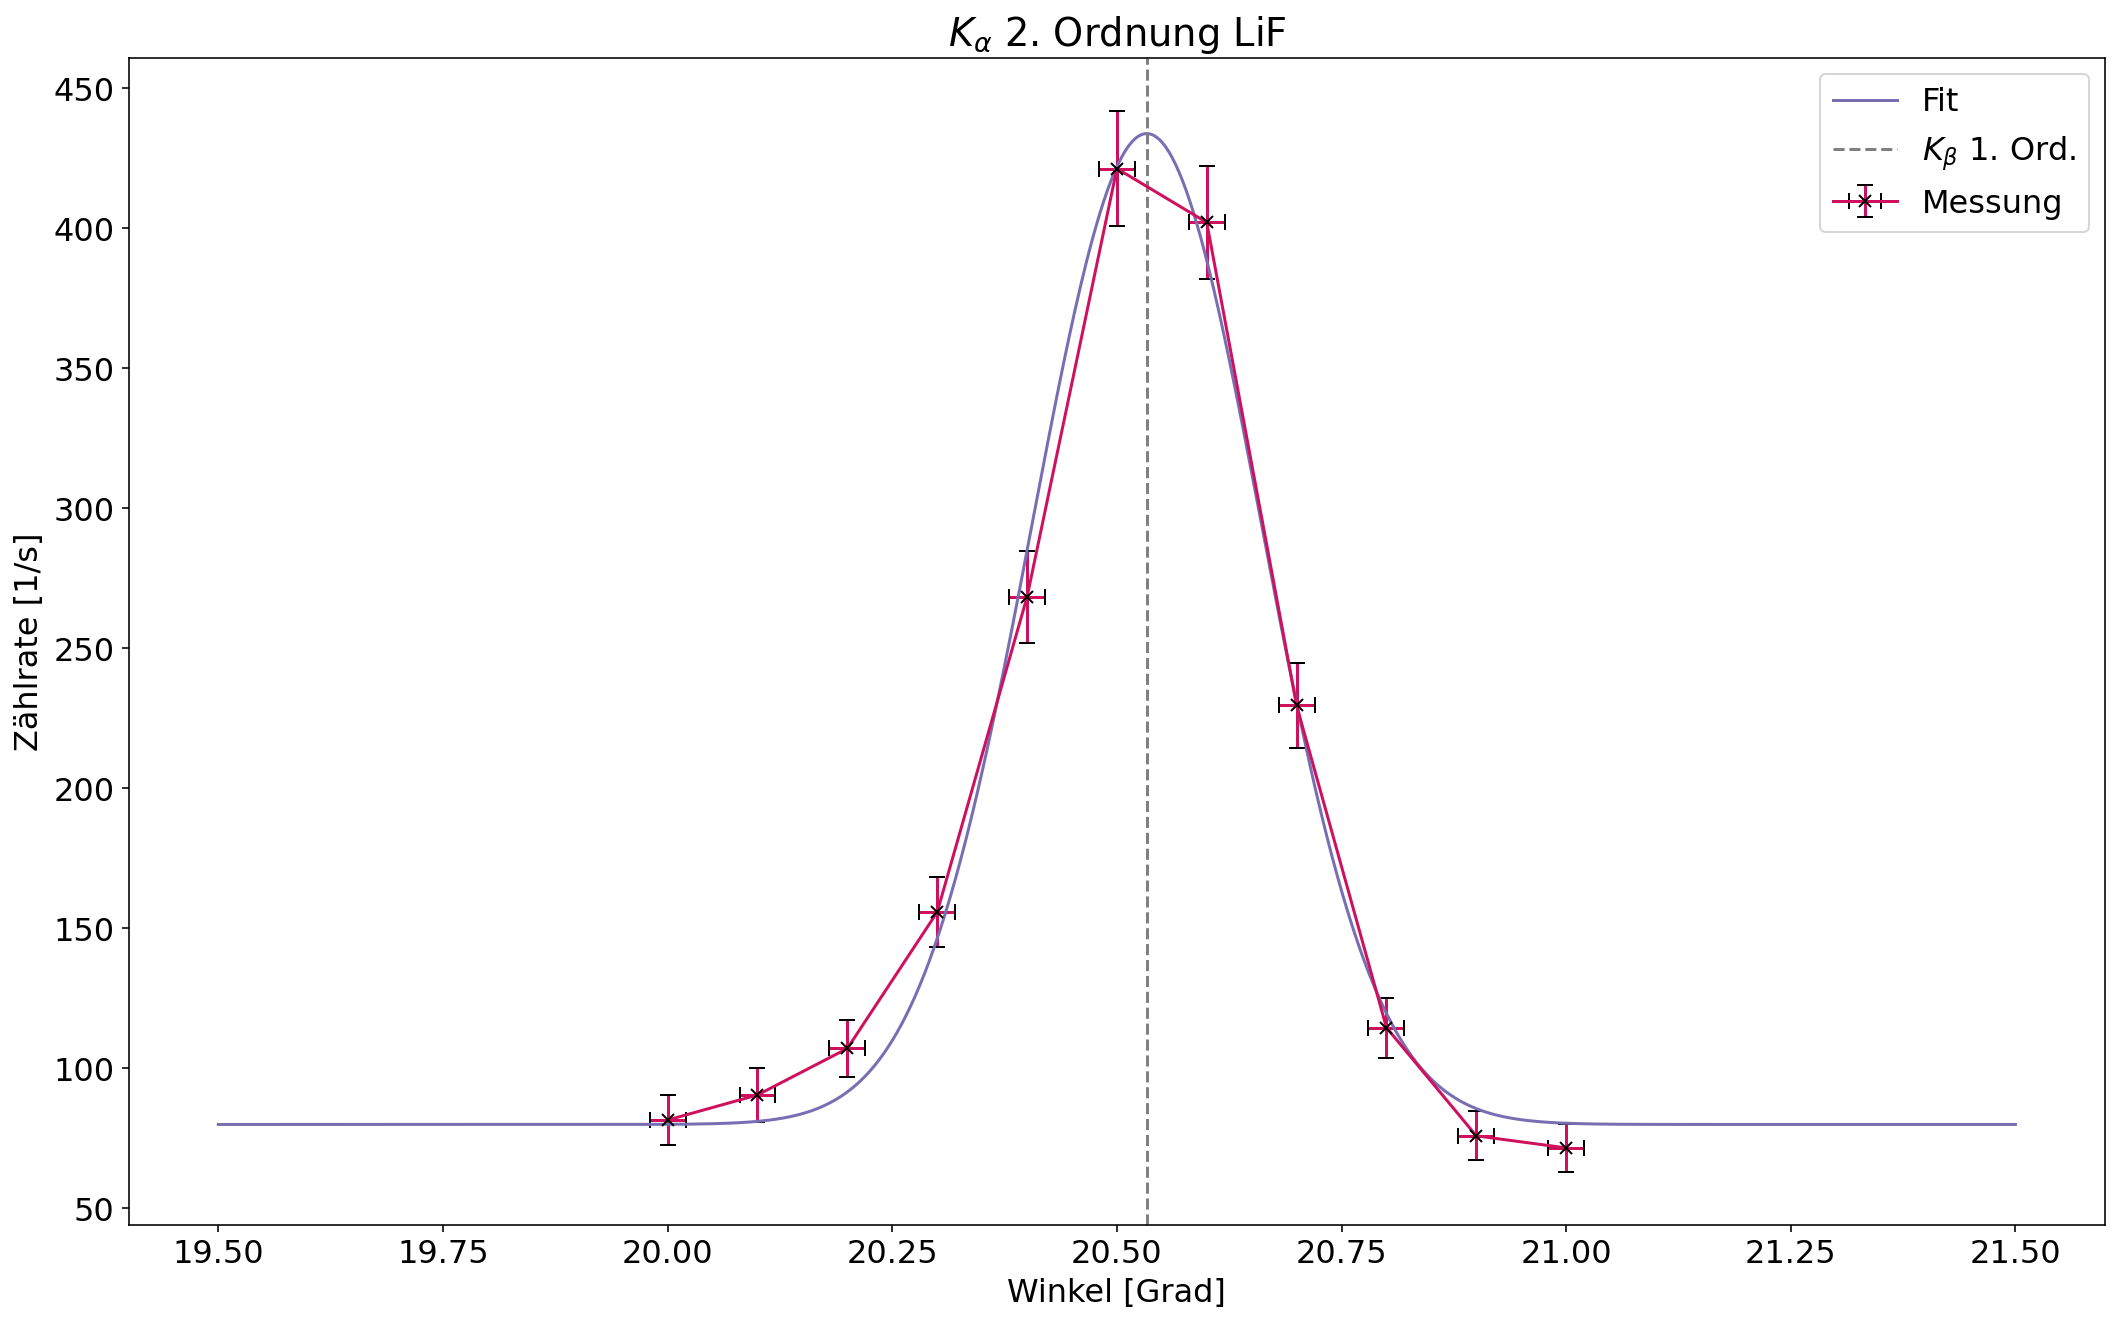

In [16]:
θ, n = np.loadtxt('data/K-Linien_zweiter_Ordnung.txt', skiprows=1, usecols=(0,1), unpack=True)
Δθ = 0.02
t = 20
Δn = np.sqrt(n)

def gaussian (x, A, mu, sig, c):
    return A / (np.sqrt(2*pi) * sig) * np.exp(-(x-mu)**2/2/sig**2) + c

index = (θ >= 20) & (θ <= 21)
popt, pcov = curve_fit(gaussian, θ[index], n[index], sigma=Δn[index], p0=[800,20, 1, 300], absolute_sigma=True)

mu = popt[1] 
mu_err = popt[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu = {mu} +/- {mu_err}')

plt.errorbar(θ[index], n[index], xerr=Δθ, yerr=Δn[index], marker='x', label='Messung')
x = np.linspace(19.5, 21.5, 1000)
plt.plot(x, gaussian(x, *popt), label='Fit')

plt.axvline(x=mu, color='gray', linestyle='--', label=r'$K_{\beta}$ 1. Ord.')

plt.title(r'$K_{\alpha}$ 2. Ordnung LiF')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'Ka_2ord')
plt.show()

In [17]:
n = np.array([1, 1, 2, 2])
λ = 2 * d * np.sin(MU * pi/180) / n
Δλ = 2 * d * np.cos(MU * pi/180) * MU_ERR / n * pi/180

for i, z in enumerate(['beta', 'alpha', 'beta', 'alpha']):
    if i <= 1:
        print(f'K_{{{z}}} 1.Ordnung ')
    else:
        print(f'K_{{{z}}} 2.Ordnung ')
    print(f'mu = {MU[i]} +/- {MU_ERR[i]}')
    print(f'λ = {λ[i]} +/- {Δλ[i]}\n')
    

K_{beta} 1.Ordnung 
mu = 8.902327194431438 +/- 0.11373332385723912
λ = 6.233350717631319e-11 +/- 7.899345345384656e-13

K_{alpha} 1.Ordnung 
mu = 10.062519943389525 +/- 0.11042384061298653
λ = 7.03782936818512e-11 +/- 7.643588701830719e-13

K_{beta} 2.Ordnung 
mu = 18.171682227843167 +/- 0.12550183571179485
λ = 6.280968506573017e-11 +/- 4.1914882534358203e-13

K_{alpha} 2.Ordnung 
mu = 20.53325089367774 +/- 0.12749788764188708
λ = 7.06412329359182e-11 +/- 4.1969435977948637e-13



In [18]:
λ_a1 = λ[1]
Δλ_a1 = Δλ[1]
λ_a2 = λ[3]
Δλ_a2 = Δλ[3]

λ_a = (λ_a1 + λ_a2) / 2
Δλ_a = 1 / 2 * np.sqrt(Δλ_a1**2 + Δλ_a2**2)

λ_a_lit = 71.1E-12 # m;
print(f'λ_a = {λ_a} +/- {Δλ_a}')
print(f'{abs(λ_a-λ_a_lit)/Δλ_a} sigma')

λ_b1 = λ[0]
Δλ_b1 = Δλ[0]
λ_b2 = λ[2]
Δλ_b2 = Δλ[2]

λ_b = (λ_b1 + λ_b2) / 2
Δλ_b = 1 / 2 * np.sqrt(Δλ_b1**2 + Δλ_b2**2)

λ_b_lit = 63.1E-12 # m;
print(f'λ_b = {λ_b} +/- {Δλ_b}')
print(f'{abs(λ_b-λ_b_lit)/Δλ_b} sigma')

λ_a = 7.05097633088847e-11 +/- 4.3600110035934973e-13
1.3537504621636054 sigma
λ_b = 6.257159612102168e-11 +/- 4.471247886897479e-13
1.1817816688865423 sigma


# 1 c)

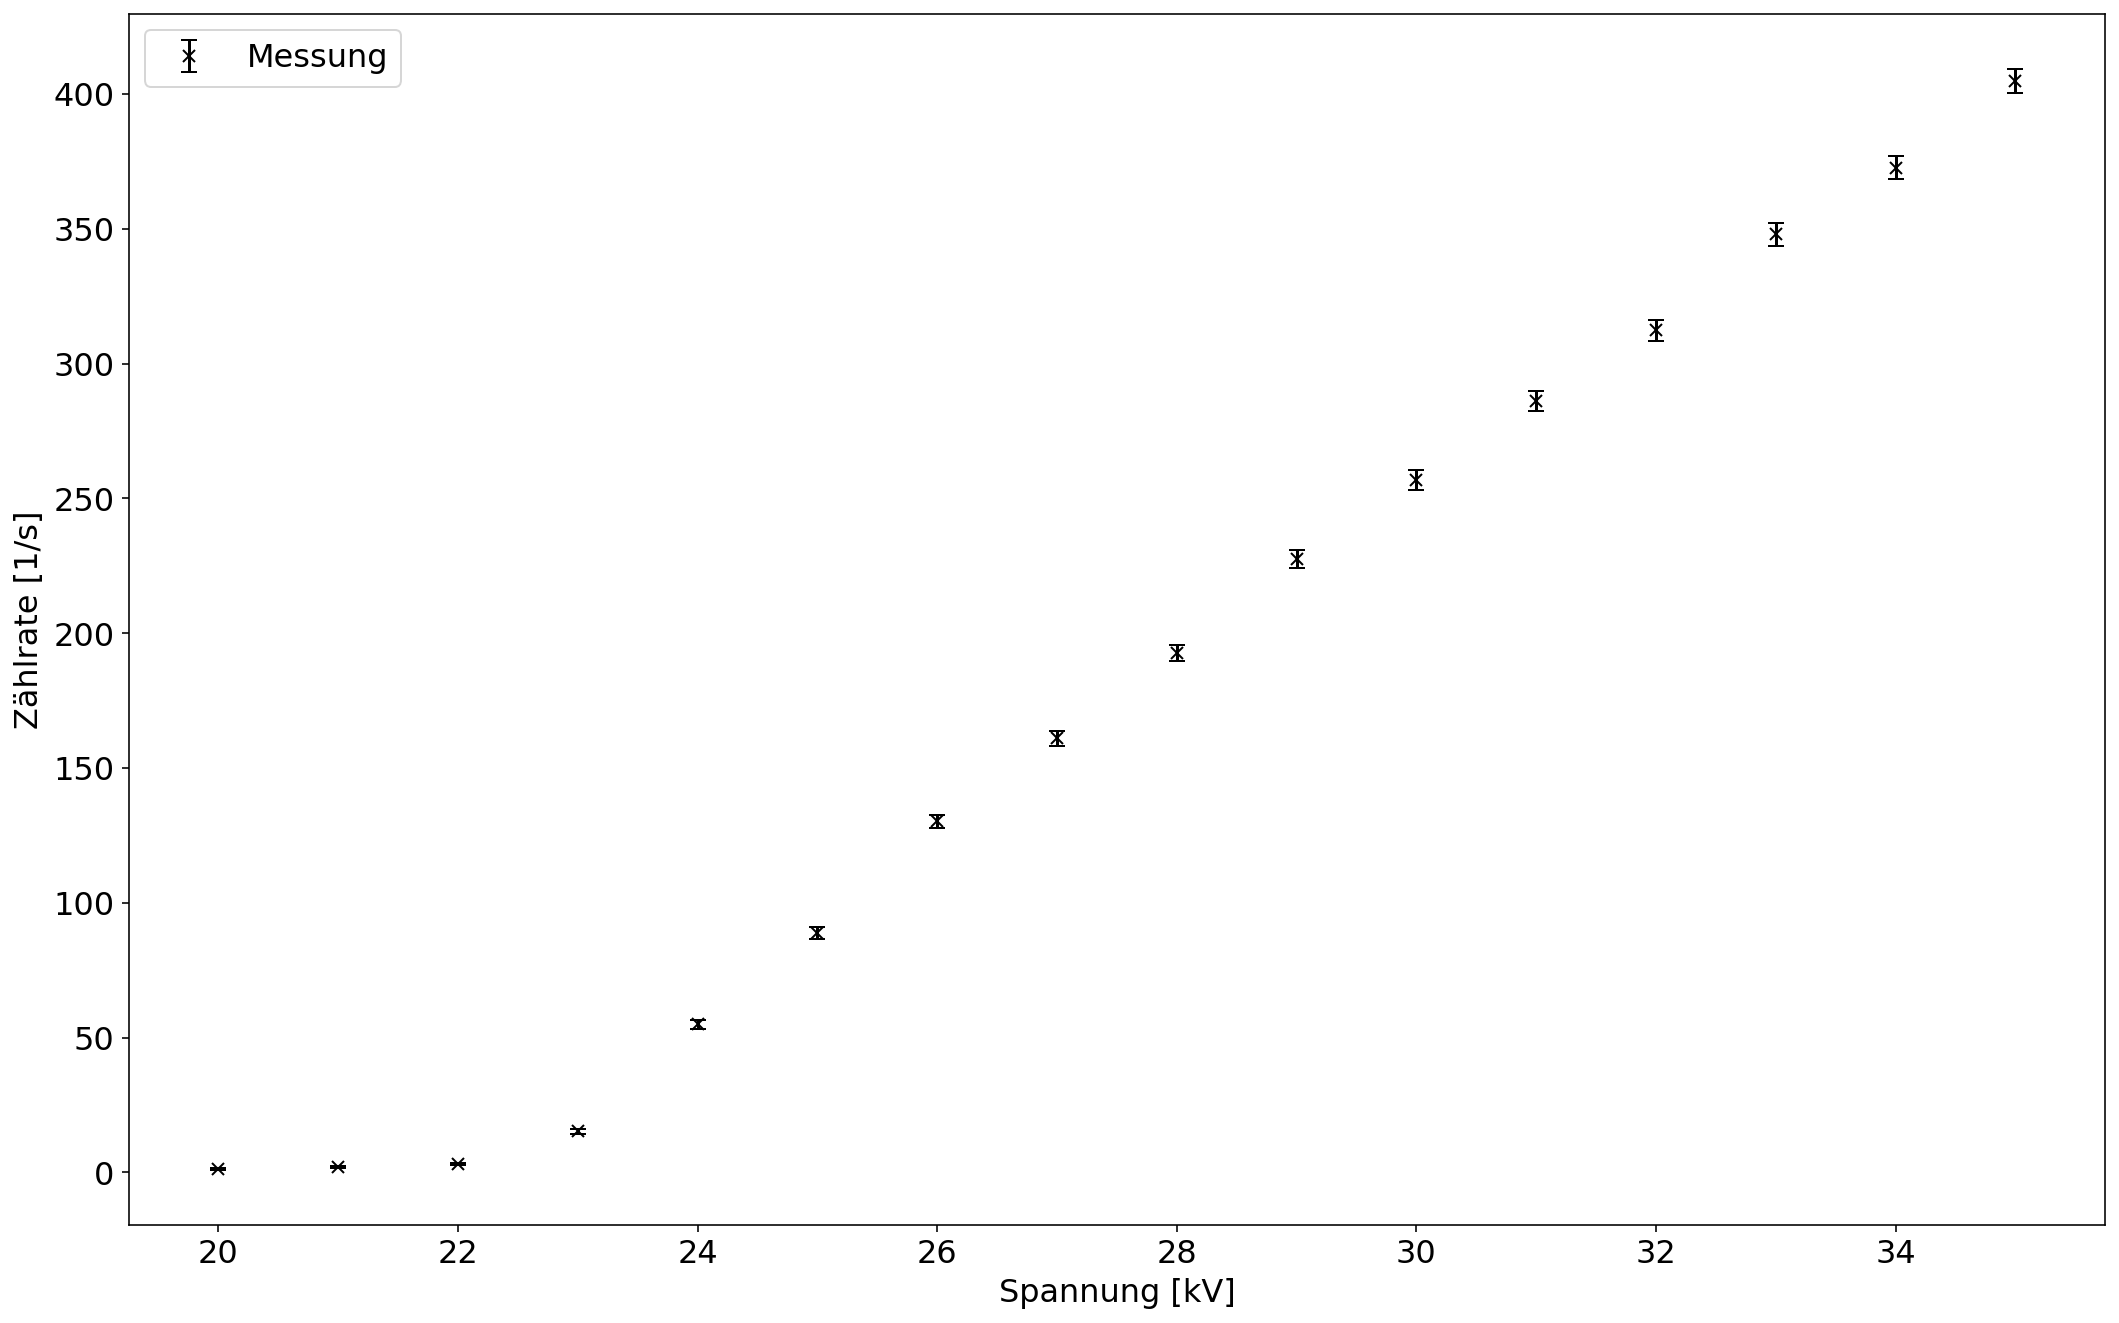

In [19]:
U, n = np.loadtxt('data/versuch_1c.txt', skiprows=1, usecols=(0,1), unpack=True)

t = 20 # s;
Δn = np.sqrt(n/t)

plt.errorbar(U, n, yerr=Δn, linestyle='none', marker='x', color='black', label='Messung')

plt.xlabel('Spannung [kV]')
plt.ylabel('Zählrate [1/s]')

plt.legend()
plt.show()

In [20]:
n0 = np.mean(n[:3])
n0_err = np.std(n[:3])
print(f'U: {U[0]} - {U[2]} kV')
print(f'n0 = {n0} +/- {n0_err}')

U: 20.0 - 22.0 kV
n0 = 2.2 +/- 0.7788880963698616


m = 33.40472499473977 +/- 0.18578773894803605
b = -749.7376129158732 +/- 4.734907552577932


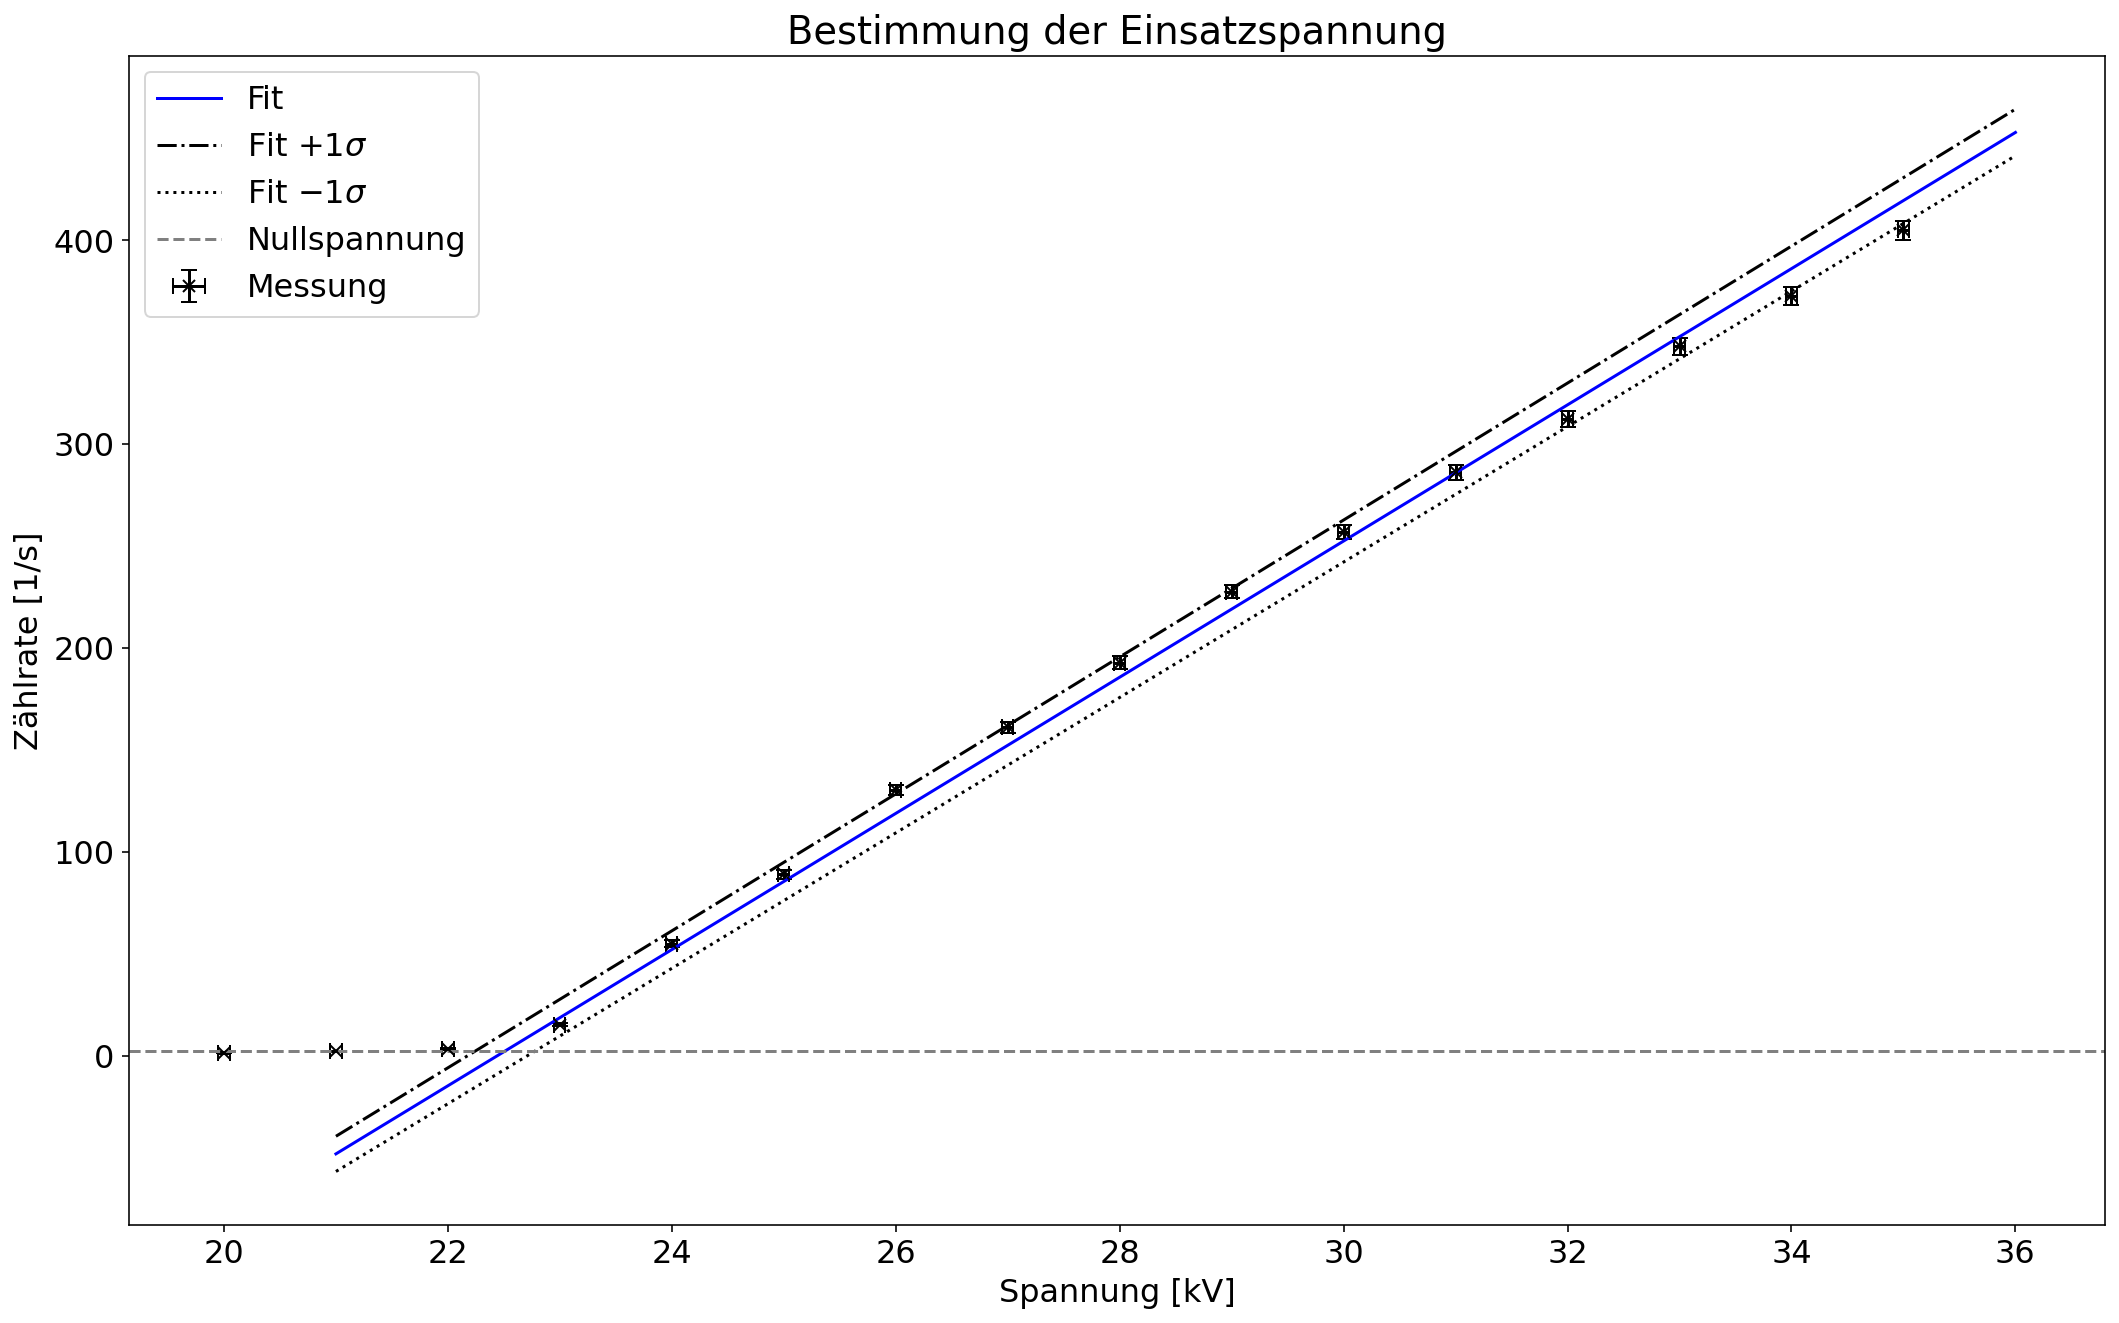

In [21]:
def linear(x, m, b):
    return m*x + b

i,j = 3, 15
popt, pcov = curve_fit(linear, U[i:], n[i:], sigma=Δn[i:], absolute_sigma=True)
popt_err = np.sqrt(pcov.diagonal())

print(f'm = {popt[0]} +/- {popt_err[0]}')
print(f'b = {popt[1]} +/- {popt_err[1]}')

plt.errorbar(U, n, xerr=0.05, yerr=Δn, linestyle='none', marker='x', color='black', label='Messung')

x = np.linspace(21, 36)
plt.plot(x, linear(x, *popt), color='b', label='Fit')
plt.plot(x, linear(x, *(popt+popt_err)), color='black', linestyle='-.', label=r'Fit $+1\sigma$')
plt.plot(x, linear(x, *(popt-popt_err)), color='black', linestyle=':',  label=r'Fit $-1\sigma$')

plt.axhline(y=n0, color='gray', linestyle='--', label='Nullspannung')

plt.xlabel('Spannung [kV]')
plt.ylabel('Zählrate [1/s]')
plt.title('Bestimmung der Einsatzspannung')
plt.legend()
plt.savefig(FIGURE_PATH+'einsatzspannung')
plt.show()

In [22]:
ROOTS = np.array([])
for c_err in [0,1,-1]:
    p = popt + c_err * popt_err

    def func2(x):
        return linear(x, *p) - n0 # Um Nullzählrate versetzte Funktion

    # Guess für Nullstelle 
    guess_root = 22 

    root = optimize.root(func2, guess_root) # bestimme Nullstelle
    
    ROOTS = np.append(ROOTS,root.x[0])
    
U_E = np.mean(ROOTS)  * 1000 # V;
ΔU_E = np.std(ROOTS) / len(ROOTS) * 1000

print(f'U_E = {U_E} +/- {ΔU_E}')

U_E = 22510.907559791816 +/- 72.65381137350309


### Wirkumsquantum

In [23]:
beta = 7.5 * pi/180 # rad;
beta_err = 0.05 * pi/180
h = e * U_E * 2 * d * np.sin(beta) / c 
h_err = h * np.sqrt((ΔU_E/U_E)**2 + (beta_err/np.tan(beta))**2)

print(f'h = {h} +/- {h_err} Js')
print(f'{abs(h-h_lit)/h_err:.2f} sigma')

h = 6.325135388904741e-34 +/- 4.6632309497812247e-36 Js
6.45 sigma


# 2. NaCl

In [24]:
MU = np.array([])
MU_ERR = np.array([])

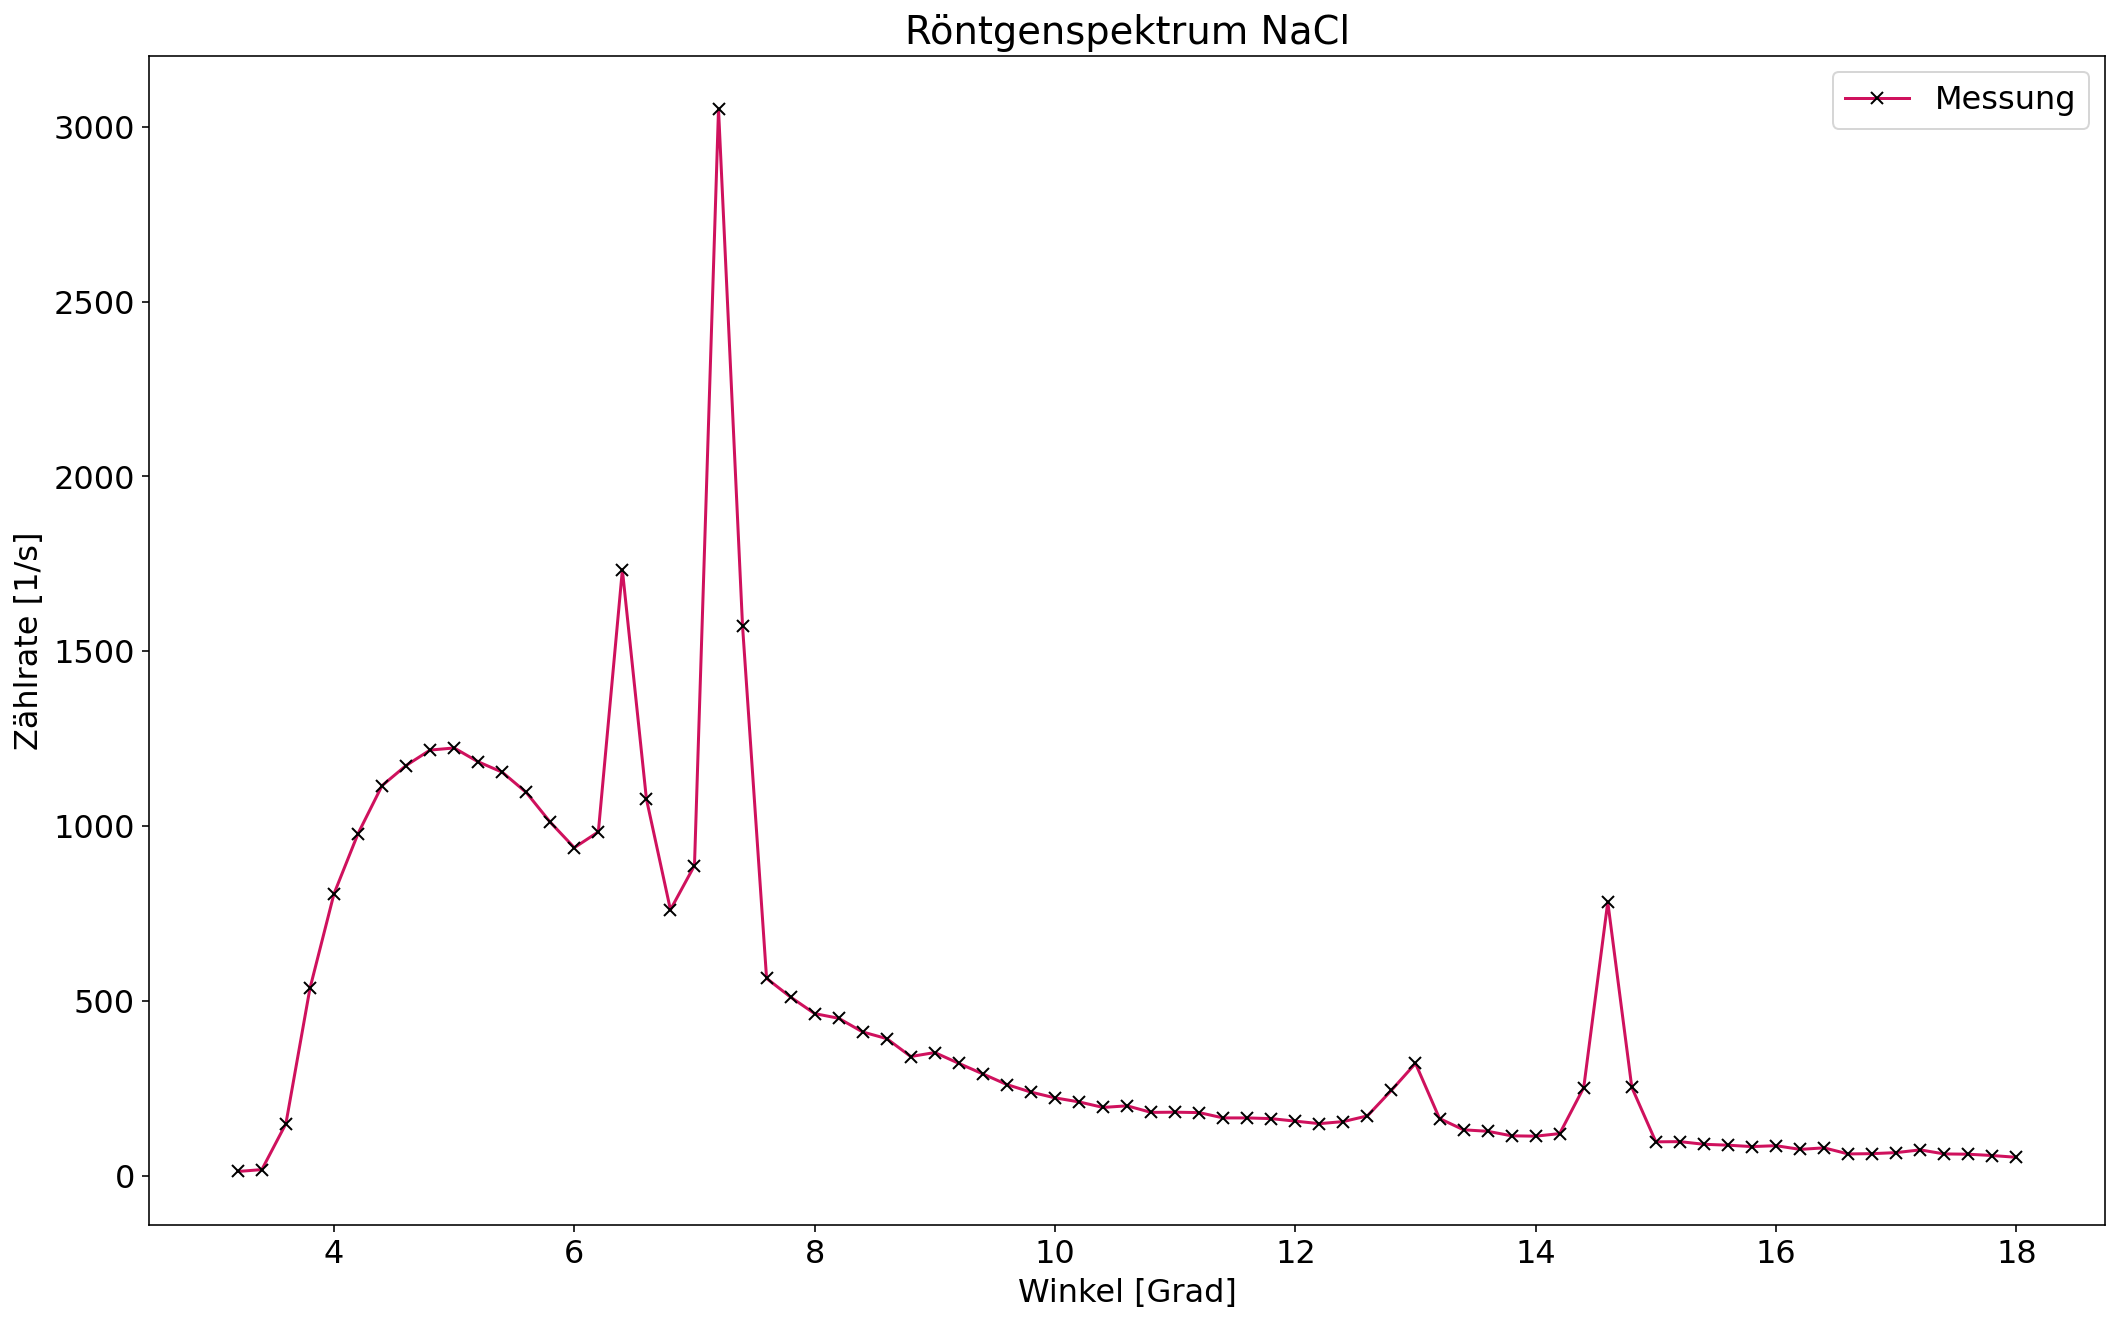

In [25]:
angle, n = np.loadtxt('data/Roentgenspektrum_NaCl.txt', skiprows=1, usecols=(0,1), unpack=True)

plt.errorbar(angle, n, marker='x', label='Messung')
plt.title('Röntgenspektrum NaCl')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'mess_NaCl')
plt.show()

mu alpha = 6.415440256371996 +/- 0.11250617298635722
mu beta = 7.237188820174756 +/- 0.12113063175001561


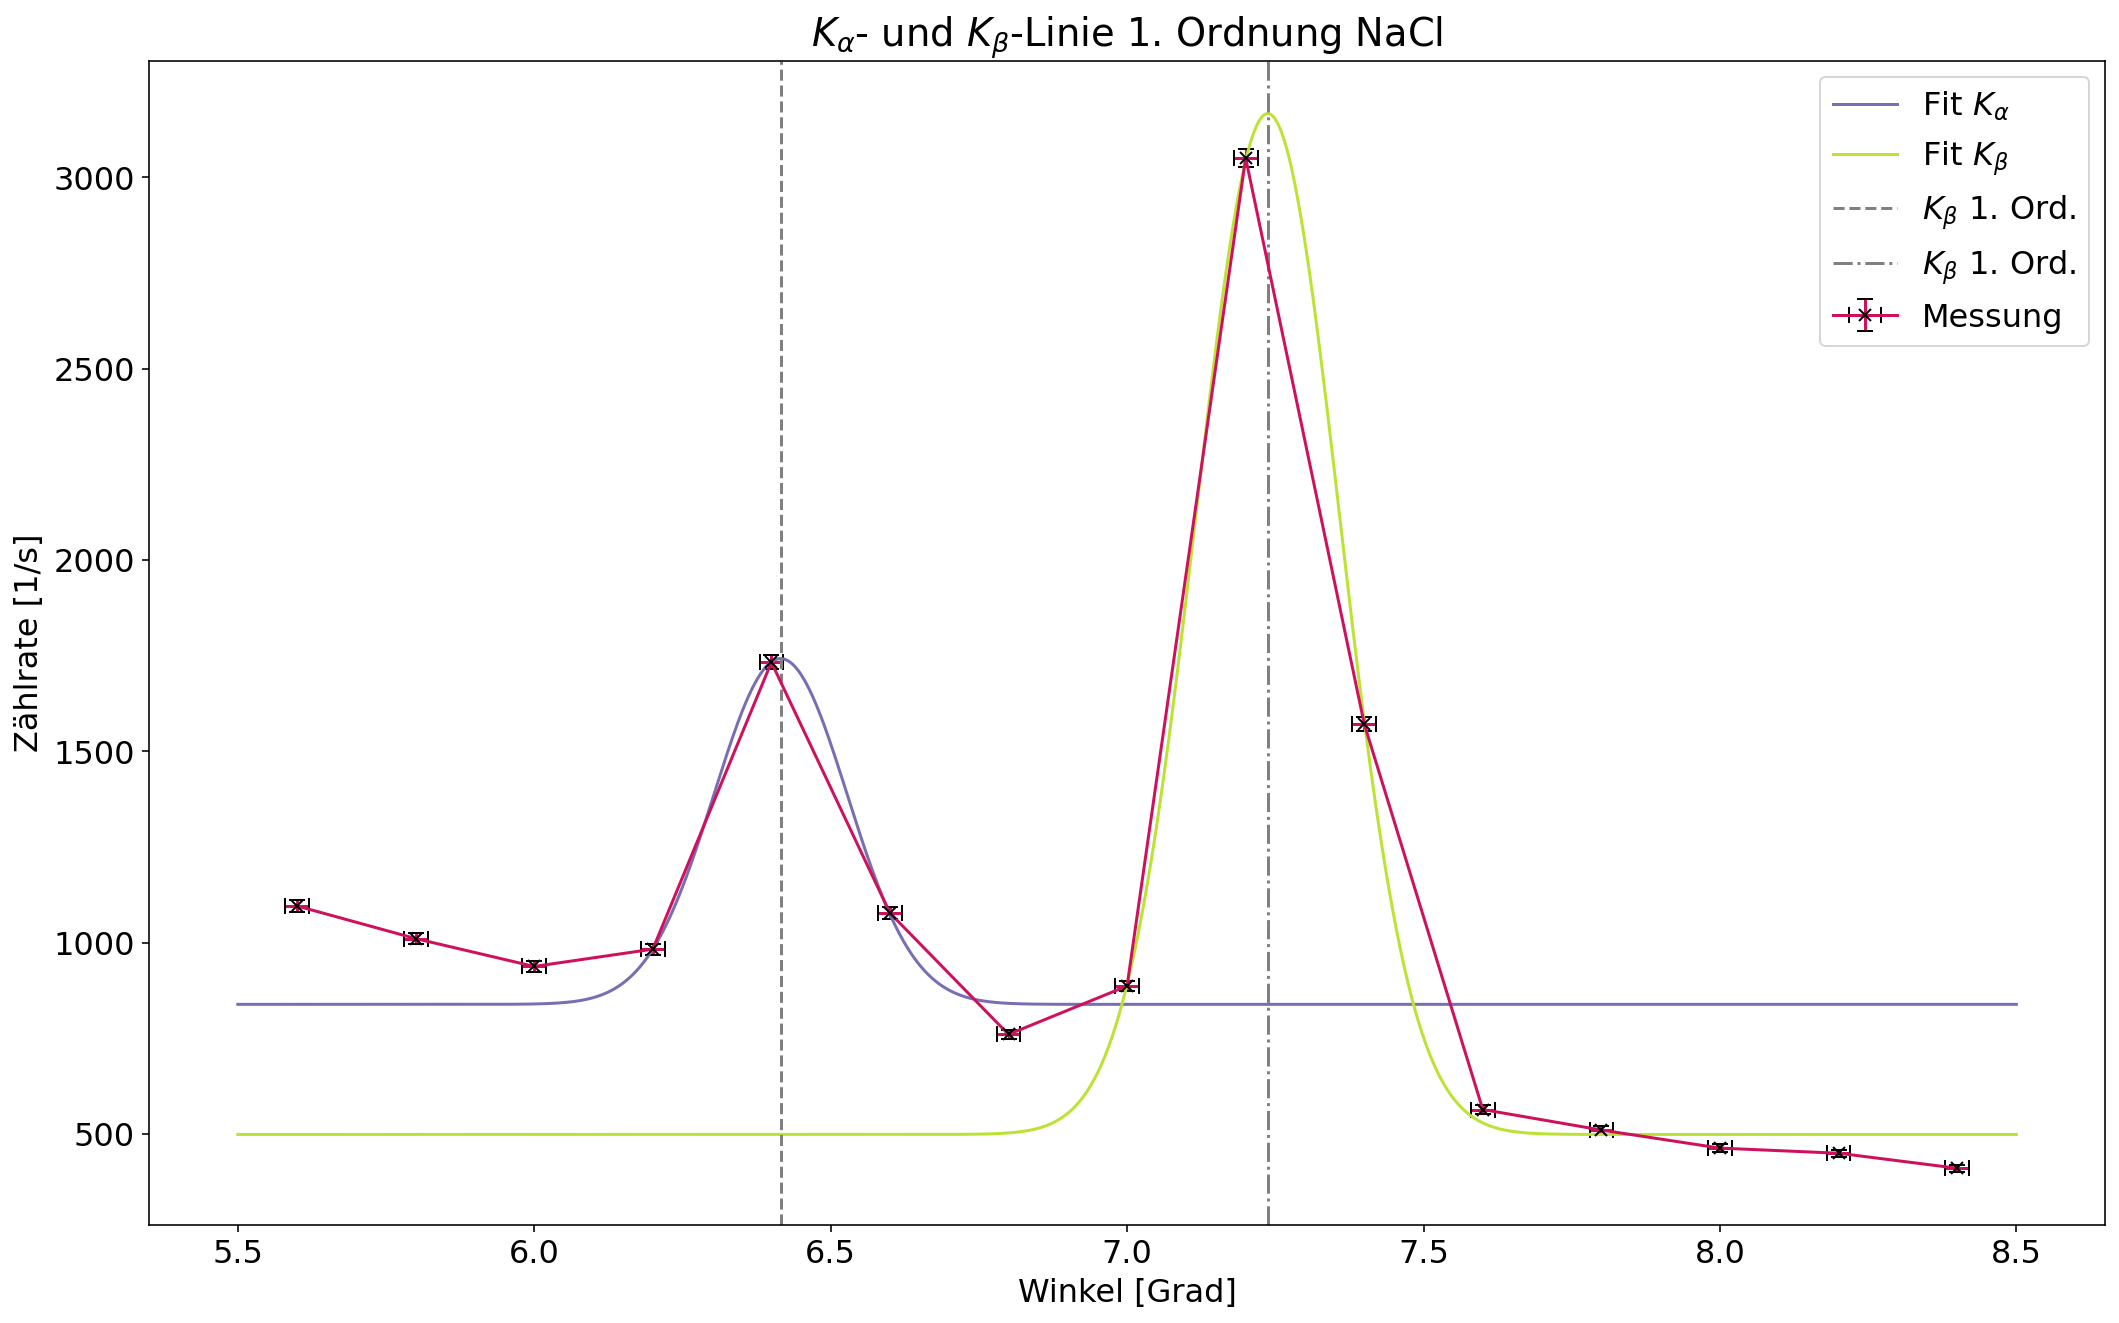

In [26]:
angle_err = 0.02
t = 5 
Δn = np.sqrt(n/t)

def gaussian (x, A, mu, sig, c):
    return A / (np.sqrt(2*pi) * sig) * np.exp(-(x-mu)**2/2/sig**2) + c

index = (angle >= 6) & (angle <= 6.8)
popt1, pcov1 = curve_fit(gaussian, angle[index], n[index], sigma=Δn[index], p0=[800,6.5, 1, 300], absolute_sigma=True)

index = (angle >= 7) & (angle <= 8)
popt2, pcov2 = curve_fit(gaussian, angle[index], n[index], sigma=Δn[index], p0=[800,7.5, 1, 300], absolute_sigma=True)

mu = popt1[1] 
mu_err = popt1[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu alpha = {mu} +/- {mu_err}')

mu = popt2[1] 
mu_err = popt2[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu beta = {mu} +/- {mu_err}')


index = (angle >= 5.5) & (angle <= 8.5)
plt.errorbar(angle[index], n[index], xerr=angle_err, yerr=Δn[index], marker='x', label='Messung')
x = np.linspace(5.5, 8.5, 1000)
plt.plot(x, gaussian(x, *popt1), label=r'Fit $K_{\alpha}$')
plt.plot(x, gaussian(x, *popt2), label=r'Fit $K_{\beta}$')

plt.axvline(x=popt1[1], color='gray', linestyle='--', label=r'$K_{\beta}$ 1. Ord.')
plt.axvline(x=popt2[1], color='gray', linestyle='-.', label=r'$K_{\beta}$ 1. Ord.')

plt.title(r'$K_{\alpha}$- und $K_{\beta}$-Linie 1. Ordnung NaCl')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'1ord_nacl')
plt.show()

mu alpha = 12.939516377771682 +/- 0.142285233110142
mu beta = 14.599822316090112 +/- 0.11692670516500372


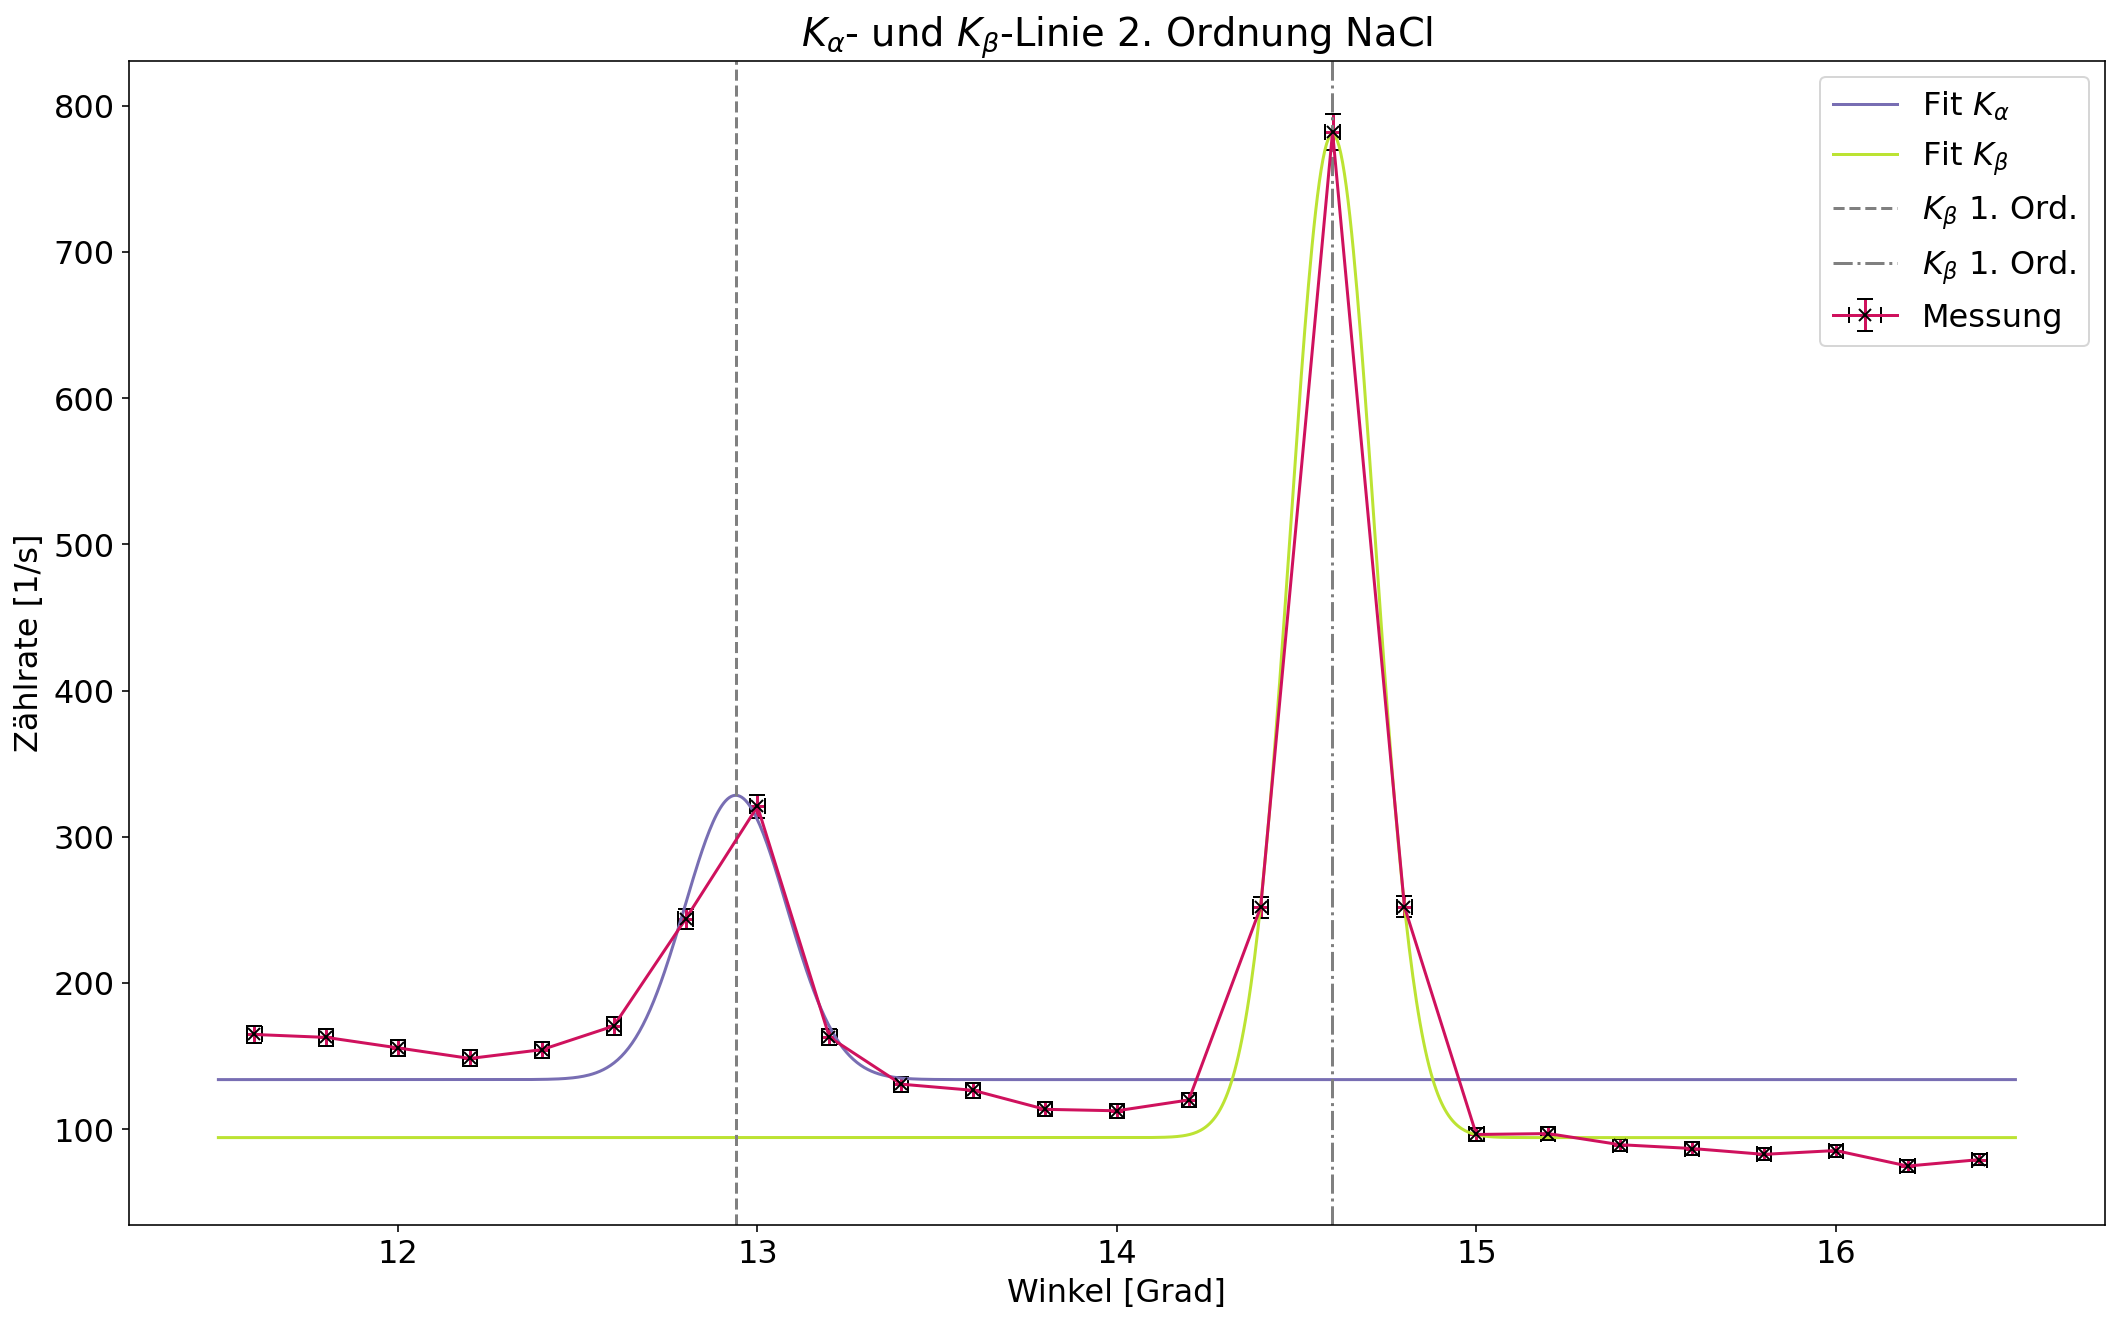

In [27]:
angle_err = 0.02
t = 5 
Δn = np.sqrt(n/t)

def gaussian (x, A, mu, sig, c):
    return A / (np.sqrt(2*pi) * sig) * np.exp(-(x-mu)**2/2/sig**2) + c

index = (angle >= 12) & (angle <= 14)
popt1, pcov1 = curve_fit(gaussian, angle[index], n[index], sigma=Δn[index], p0=[800, 13, 1, 300], absolute_sigma=True)

index = (angle >= 14) & (angle <= 16)
popt2, pcov2 = curve_fit(gaussian, angle[index], n[index], sigma=Δn[index], p0=[800, 15, 1, 300], absolute_sigma=True)

mu = popt1[1] 
mu_err = popt1[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu alpha = {mu} +/- {mu_err}')

mu = popt2[1] 
mu_err = popt2[2] 
MU = np.append(MU, mu)
MU_ERR = np.append(MU_ERR, mu_err)
print(f'mu beta = {mu} +/- {mu_err}')


index = (angle >= 11.5) & (angle <= 16.5)
plt.errorbar(angle[index], n[index], xerr=angle_err, yerr=Δn[index], marker='x', label='Messung')
x = np.linspace(11.5, 16.5, 1000)
plt.plot(x, gaussian(x, *popt1), label=r'Fit $K_{\alpha}$')
plt.plot(x, gaussian(x, *popt2), label=r'Fit $K_{\beta}$')

plt.axvline(x=popt1[1], color='gray', linestyle='--', label=r'$K_{\beta}$ 1. Ord.')
plt.axvline(x=popt2[1], color='gray', linestyle='-.', label=r'$K_{\beta}$ 1. Ord.')

plt.title(r'$K_{\alpha}$- und $K_{\beta}$-Linie 2. Ordnung NaCl')
plt.xlabel('Winkel [Grad]')
plt.ylabel('Zählrate [1/s]')
plt.legend()
plt.savefig(FIGURE_PATH+'2ord_nacl')
plt.show()

In [28]:
d = np.array([1,1,2,2]) * np.array([λ_b, λ_a, λ_b, λ_a]) / (2 * np.sin(MU * pi/180))
d_err = d * np.sqrt((np.array([Δλ_b, Δλ_a, Δλ_b, Δλ_a])/np.array([λ_b, λ_a, λ_b, λ_a]))**2 
                     + (MU_ERR * pi/180 / np.tan(MU * pi/180))**2)

for i, z in enumerate(['b', 'a', 'b', 'a']):
    if i <= 1:
        print(f'K_{z} 1.Ordnung')
    else:
        print(f'K_{z} 2.Ordnung')
    print(f'd = {d[i]} +/- {d_err[i]} m')
    print(f'mu = {MU[i]} +/- {MU_ERR[i]} grad\n')

K_b 1.Ordnung
d = 2.7999564237797276e-10 +/- 5.283199853025816e-12 m
mu = 6.415440256371996 +/- 0.11250617298635722 grad

K_a 1.Ordnung
d = 2.798513846954506e-10 +/- 4.969997892784683e-12 m
mu = 7.237188820174756 +/- 0.12113063175001561 grad

K_b 2.Ordnung
d = 2.794343531094639e-10 +/- 3.6206795381682064e-12 m
mu = 12.939516377771682 +/- 0.142285233110142 grad

K_a 2.Ordnung
d = 2.7972698970529365e-10 +/- 2.791930689896687e-12 m
mu = 14.599822316090112 +/- 0.11692670516500372 grad



In [29]:
d_avg = np.mean(d)
d_err_stat = np.std(d)
d_err_sys = 1/len(d) * np.sqrt(np.sum([x**2 for x in d_err]))

print(f'd = {d_avg} +/- {d_err_stat} stat. +/- {d_err_sys} sys.')
d_avg_err = d_err_sys

d = 2.7975209247204523e-10 +/- 2.06617977036273e-13 stat. +/- 2.143555414442806e-12 sys.


In [30]:
a = 2 * d_avg
a_err = 2 * d_avg_err
print(f'a = {a} +/- {a_err}')

a = 5.595041849440905e-10 +/- 4.287110828885612e-12


In [31]:
M_mol = 58.44 # g mol^{-1}; Molare Masse NaCl
rho = 2.164e6 # g m^{-3}; Dichte NaCl

N_A = 1 / 2 * M_mol / rho  * 1 / d_avg**3
N_A_err = 3 * N_A * d_avg_err / d_avg

print(f'N_A = {N_A} +/- {N_A_err}')
print(f'{np.abs(N_A-N_A_lit)/N_A_err:.2f} sigma')

N_A = 6.167411472368604e+23 +/- 1.4177039540120816e+22
1.02 sigma
